In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
#downloading the datasets
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown
#data set
url = "https://drive.google.com/u/0/uc?id=1k6F-eF-USZ-obPGCatD229C-_6wtsGfo&export=download"
output = "data.zip"
gdown.download(url, output)
!unzip data.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1k6F-eF-USZ-obPGCatD229C-_6wtsGfo&export=download
From (redirected): https://drive.google.com/uc?id=1k6F-eF-USZ-obPGCatD229C-_6wtsGfo&export=download&confirm=t&uuid=1079a0db-7c96-4128-8ef5-55ee8169778c
To: /content/data.zip
100%|██████████| 173M/173M [00:02<00:00, 63.6MB/s]


Archive:  data.zip
replace data/test/images/0_2300.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/test/images/0_2300.png  
replace data/test/images/0_2301.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data")):
    print(folder)
    for im in tqdm(os.listdir("data/"+folder+"/images/")):
        if folder == "clean":
            clean.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_clean.append(0)
        elif folder == "clean_validation":
            val.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_val.append(0)
        elif folder== "jammed_channel":
            anomalies.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_anomalies.append(1)
        else:
          test.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_test.append(mapping[int(im[0])])
    ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                   

  0%|          | 0/4 [00:00<?, ?it/s]

jammed_channel



 25%|██▌       | 1/4 [00:08<00:25,  8.64s/it]

test



 50%|█████     | 2/4 [00:15<00:15,  7.52s/it]

clean



 75%|███████▌  | 3/4 [00:38<00:14, 14.80s/it]

clean_validation



100%|██████████| 4/4 [00:42<00:00, 10.68s/it]


In [5]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [6]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



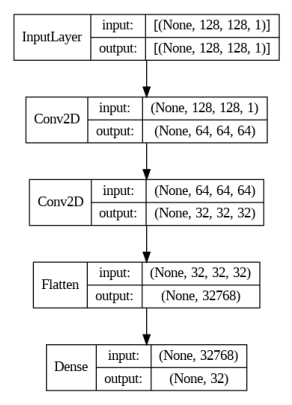

Summary of the decoder:



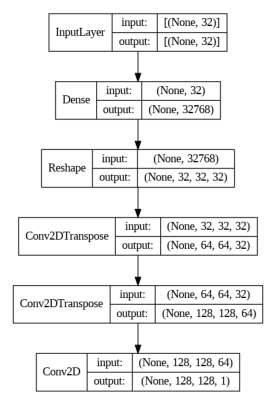

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [8]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 16s 48ms/step - loss: 0.0353 - val_loss: 0.0351
Epoch 2/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0346 - val_loss: 0.0347
Epoch 3/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0300 - val_loss: 0.0279
Epoch 4/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0276 - val_loss: 0.0278
Epoch 5/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0275 - val_loss: 0.0277
Epoch 6/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0275 - val_loss: 0.0277
Epoch 7/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0275 - val_loss: 0.0276
Epoch 8/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0275 - val_loss: 0.0277
Epoch 9/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0275 - val_loss: 0.0276
Epoch 10/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0275 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

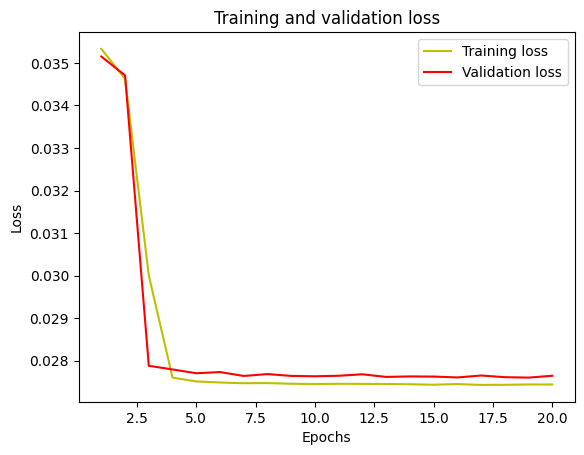

In [9]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 1s 21ms/step


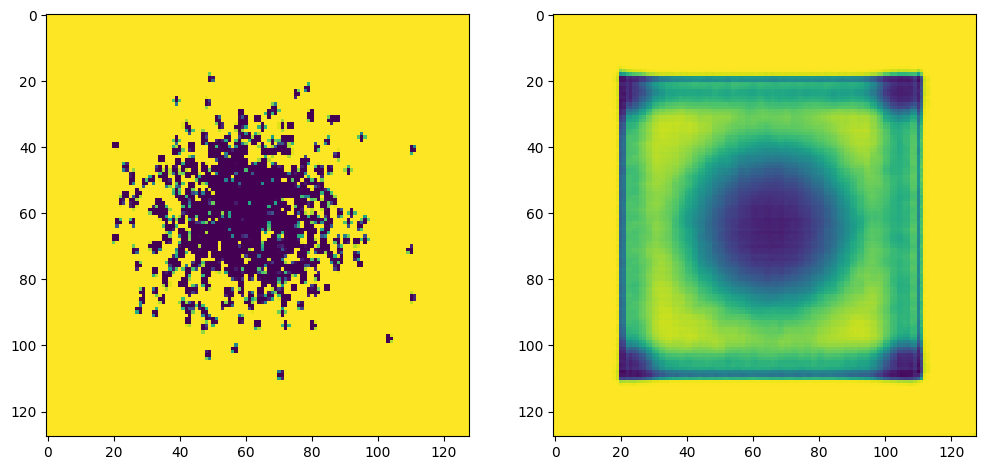

In [11]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [12]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 39ms/step - loss: 0.0485
Validation error 0.027646712958812714
Anomaly error 0.04852306842803955
The reconstruction error of the jammed channel is  1.7551116655469254  more than the clean channel


In [13]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_recon_error, stdev_recon_error

In [14]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step - loss: 0.0289


  0%|          | 1/600 [00:00<02:09,  4.63it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0297


  0%|          | 3/600 [00:00<01:14,  8.04it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0270


  1%|          | 5/600 [00:00<01:08,  8.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0234


  1%|          | 7/600 [00:00<01:02,  9.56it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0230


  2%|▏         | 9/600 [00:00<00:59,  9.92it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0250


  2%|▏         | 11/600 [00:01<00:59,  9.89it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0263


  2%|▏         | 13/600 [00:01<00:57, 10.14it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0302


  2%|▎         | 15/600 [00:01<00:56, 10.26it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0284


  3%|▎         | 17/600 [00:01<00:54, 10.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0298


  3%|▎         | 19/600 [00:01<00:54, 10.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0264


  4%|▎         | 21/600 [00:02<00:55, 10.39it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0289


  4%|▍         | 23/600 [00:02<00:53, 10.84it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0285


  4%|▍         | 25/600 [00:02<00:53, 10.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0271


  4%|▍         | 27/600 [00:02<00:51, 11.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0248


  5%|▍         | 29/600 [00:02<00:47, 12.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0246


  5%|▌         | 31/600 [00:02<00:44, 12.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


  6%|▌         | 33/600 [00:03<00:43, 12.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


  6%|▌         | 35/600 [00:03<00:41, 13.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


  6%|▌         | 37/600 [00:03<00:40, 13.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0264


  6%|▋         | 39/600 [00:03<00:40, 13.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0249


  7%|▋         | 41/600 [00:03<00:40, 13.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


  7%|▋         | 43/600 [00:03<00:40, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0270


  8%|▊         | 45/600 [00:03<00:40, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


  8%|▊         | 47/600 [00:04<00:39, 14.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


  8%|▊         | 49/600 [00:04<00:39, 13.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


  8%|▊         | 51/600 [00:04<00:39, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0277


  9%|▉         | 53/600 [00:04<00:39, 13.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0281


  9%|▉         | 55/600 [00:04<00:39, 13.94it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0284


 10%|▉         | 57/600 [00:04<00:39, 13.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 10%|▉         | 59/600 [00:04<00:38, 13.88it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0292


 10%|█         | 61/600 [00:05<00:38, 13.89it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0299


 10%|█         | 63/600 [00:05<00:37, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0238


 11%|█         | 65/600 [00:05<00:36, 14.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0287


 11%|█         | 67/600 [00:05<00:35, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


 12%|█▏        | 69/600 [00:05<00:35, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


 12%|█▏        | 71/600 [00:05<00:35, 14.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


 12%|█▏        | 73/600 [00:05<00:36, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0232


 12%|█▎        | 75/600 [00:05<00:34, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


 13%|█▎        | 77/600 [00:06<00:34, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0465


 13%|█▎        | 79/600 [00:06<00:34, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 14%|█▎        | 81/600 [00:06<00:34, 15.13it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0257


 14%|█▍        | 83/600 [00:06<00:35, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 14%|█▍        | 85/600 [00:06<00:35, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0236


 14%|█▍        | 87/600 [00:06<00:34, 14.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0285


 15%|█▍        | 89/600 [00:06<00:34, 14.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0292


 15%|█▌        | 91/600 [00:07<00:34, 14.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


 16%|█▌        | 93/600 [00:07<00:33, 15.21it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0283


 16%|█▌        | 95/600 [00:07<00:33, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0262


 16%|█▌        | 97/600 [00:07<00:33, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 16%|█▋        | 99/600 [00:07<00:33, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0298


 17%|█▋        | 101/600 [00:07<00:32, 15.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0234


 17%|█▋        | 103/600 [00:07<00:32, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0297


 18%|█▊        | 105/600 [00:07<00:31, 15.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0236


 18%|█▊        | 107/600 [00:08<00:32, 15.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0255


 18%|█▊        | 109/600 [00:08<00:31, 15.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0283


 18%|█▊        | 111/600 [00:08<00:31, 15.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0239


 19%|█▉        | 113/600 [00:08<00:31, 15.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0278


 19%|█▉        | 115/600 [00:08<00:32, 14.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 20%|█▉        | 117/600 [00:08<00:33, 14.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0265


 20%|█▉        | 119/600 [00:08<00:33, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


 20%|██        | 121/600 [00:09<00:33, 14.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 20%|██        | 123/600 [00:09<00:32, 14.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0244


 21%|██        | 125/600 [00:09<00:32, 14.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0276


 21%|██        | 127/600 [00:09<00:32, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0241


 22%|██▏       | 129/600 [00:09<00:32, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 22%|██▏       | 131/600 [00:09<00:32, 14.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0269


 22%|██▏       | 133/600 [00:09<00:32, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 22%|██▎       | 135/600 [00:10<00:33, 13.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0464


 23%|██▎       | 137/600 [00:10<00:31, 14.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0256


 23%|██▎       | 139/600 [00:10<00:31, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0230


 24%|██▎       | 141/600 [00:10<00:32, 14.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0235


 24%|██▍       | 143/600 [00:10<00:32, 13.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 24%|██▍       | 145/600 [00:10<00:31, 14.27it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0285


 24%|██▍       | 147/600 [00:10<00:31, 14.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0271


 25%|██▍       | 149/600 [00:11<00:30, 14.64it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0297


 25%|██▌       | 151/600 [00:11<00:29, 14.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0283


 26%|██▌       | 153/600 [00:11<00:29, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 26%|██▌       | 155/600 [00:11<00:29, 15.28it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0257


 26%|██▌       | 157/600 [00:11<00:29, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0261


 26%|██▋       | 159/600 [00:11<00:29, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


 27%|██▋       | 161/600 [00:11<00:29, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0291


 27%|██▋       | 163/600 [00:11<00:28, 15.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


 28%|██▊       | 165/600 [00:12<00:29, 14.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 28%|██▊       | 167/600 [00:12<00:29, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


 28%|██▊       | 169/600 [00:12<00:28, 14.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0302


 28%|██▊       | 171/600 [00:12<00:28, 15.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 29%|██▉       | 173/600 [00:12<00:27, 15.39it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0318


 29%|██▉       | 175/600 [00:12<00:31, 13.45it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0269


 30%|██▉       | 177/600 [00:12<00:34, 12.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0274


 30%|██▉       | 179/600 [00:13<00:34, 12.22it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0306


 30%|███       | 181/600 [00:13<00:34, 12.05it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0260


 30%|███       | 183/600 [00:13<00:36, 11.56it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0282


 31%|███       | 185/600 [00:13<00:37, 10.99it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0253


 31%|███       | 187/600 [00:13<00:38, 10.80it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0282


 32%|███▏      | 189/600 [00:14<00:37, 10.88it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0272


 32%|███▏      | 191/600 [00:14<00:38, 10.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0233


 32%|███▏      | 193/600 [00:14<00:38, 10.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0288


 32%|███▎      | 195/600 [00:14<00:37, 10.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0280


 33%|███▎      | 197/600 [00:14<00:36, 10.99it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0282


 33%|███▎      | 199/600 [00:15<00:36, 10.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0270


 34%|███▎      | 201/600 [00:15<00:34, 11.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 34%|███▍      | 203/600 [00:15<00:31, 12.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0230


 34%|███▍      | 205/600 [00:15<00:30, 12.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0235


 34%|███▍      | 207/600 [00:15<00:28, 13.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


 35%|███▍      | 209/600 [00:15<00:28, 13.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0226


 35%|███▌      | 211/600 [00:15<00:27, 14.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0297


 36%|███▌      | 213/600 [00:15<00:27, 14.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0264


 36%|███▌      | 215/600 [00:16<00:26, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0258


 36%|███▌      | 217/600 [00:16<00:26, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 36%|███▋      | 219/600 [00:16<00:26, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0298


 37%|███▋      | 221/600 [00:16<00:25, 14.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 37%|███▋      | 223/600 [00:16<00:25, 14.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0271


 38%|███▊      | 225/600 [00:16<00:26, 13.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0294


 38%|███▊      | 227/600 [00:16<00:26, 13.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0251


 38%|███▊      | 229/600 [00:17<00:25, 14.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0278


 38%|███▊      | 231/600 [00:17<00:25, 14.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0275


 39%|███▉      | 233/600 [00:17<00:25, 14.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0283


 39%|███▉      | 235/600 [00:17<00:25, 14.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0303


 40%|███▉      | 237/600 [00:17<00:25, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0240


 40%|███▉      | 239/600 [00:17<00:26, 13.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0257


 40%|████      | 241/600 [00:17<00:26, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0310


 40%|████      | 243/600 [00:18<00:25, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


 41%|████      | 245/600 [00:18<00:24, 14.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0260


 41%|████      | 247/600 [00:18<00:23, 14.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0230


 42%|████▏     | 249/600 [00:18<00:23, 14.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0287


 42%|████▏     | 251/600 [00:18<00:24, 14.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0284


 42%|████▏     | 253/600 [00:18<00:24, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 42%|████▎     | 255/600 [00:18<00:23, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 43%|████▎     | 257/600 [00:19<00:23, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0262


 43%|████▎     | 259/600 [00:19<00:23, 14.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0240


 44%|████▎     | 261/600 [00:19<00:23, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


 44%|████▍     | 263/600 [00:19<00:22, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0275


 44%|████▍     | 265/600 [00:19<00:22, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0309


 44%|████▍     | 267/600 [00:19<00:21, 15.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0277


 45%|████▍     | 269/600 [00:19<00:22, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0315


 45%|████▌     | 271/600 [00:19<00:22, 14.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 46%|████▌     | 273/600 [00:20<00:23, 14.20it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0300


 46%|████▌     | 275/600 [00:20<00:22, 14.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0278


 46%|████▌     | 277/600 [00:20<00:21, 14.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0283


 46%|████▋     | 279/600 [00:20<00:22, 14.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0303


 47%|████▋     | 281/600 [00:20<00:22, 14.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0227


 47%|████▋     | 283/600 [00:20<00:22, 13.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0300


 48%|████▊     | 285/600 [00:20<00:22, 14.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0241


 48%|████▊     | 287/600 [00:21<00:21, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0301


 48%|████▊     | 289/600 [00:21<00:21, 14.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0218


 48%|████▊     | 291/600 [00:21<00:21, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0257


 49%|████▉     | 293/600 [00:21<00:21, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 49%|████▉     | 295/600 [00:21<00:21, 14.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0261


 50%|████▉     | 297/600 [00:21<00:22, 13.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0238


 50%|████▉     | 299/600 [00:21<00:21, 14.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0295


 50%|█████     | 301/600 [00:22<00:21, 14.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0283


 50%|█████     | 303/600 [00:22<00:20, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0242


 51%|█████     | 305/600 [00:22<00:20, 14.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0261


 51%|█████     | 307/600 [00:22<00:20, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0278


 52%|█████▏    | 309/600 [00:22<00:20, 14.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0280


 52%|█████▏    | 311/600 [00:22<00:20, 13.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


 52%|█████▏    | 313/600 [00:22<00:20, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0281


 52%|█████▎    | 315/600 [00:23<00:20, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


 53%|█████▎    | 317/600 [00:23<00:20, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0262


 53%|█████▎    | 319/600 [00:23<00:19, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


 54%|█████▎    | 321/600 [00:23<00:19, 14.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0271


 54%|█████▍    | 323/600 [00:23<00:19, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0262


 54%|█████▍    | 325/600 [00:23<00:19, 14.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0284


 55%|█████▍    | 327/600 [00:23<00:18, 14.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 55%|█████▍    | 329/600 [00:24<00:18, 14.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0277


 55%|█████▌    | 331/600 [00:24<00:18, 14.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0247


 56%|█████▌    | 333/600 [00:24<00:17, 15.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0280


 56%|█████▌    | 335/600 [00:24<00:17, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 56%|█████▌    | 337/600 [00:24<00:17, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0295


 56%|█████▋    | 339/600 [00:24<00:17, 14.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0262


 57%|█████▋    | 341/600 [00:24<00:18, 14.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0303


 57%|█████▋    | 343/600 [00:25<00:18, 14.25it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0256


 57%|█████▊    | 345/600 [00:25<00:19, 12.84it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0279


 58%|█████▊    | 347/600 [00:25<00:20, 12.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0239


 58%|█████▊    | 349/600 [00:25<00:20, 12.27it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0255


 58%|█████▊    | 351/600 [00:25<00:21, 11.84it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0298


 59%|█████▉    | 353/600 [00:25<00:22, 11.05it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0304


 59%|█████▉    | 355/600 [00:26<00:22, 10.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0303


 60%|█████▉    | 357/600 [00:26<00:22, 10.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0300


 60%|█████▉    | 359/600 [00:26<00:22, 10.83it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0280


 60%|██████    | 361/600 [00:26<00:21, 11.10it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0286


 60%|██████    | 363/600 [00:26<00:21, 11.19it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0241


 61%|██████    | 365/600 [00:27<00:20, 11.30it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0284


 61%|██████    | 367/600 [00:27<00:20, 11.35it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0242


 62%|██████▏   | 369/600 [00:27<00:20, 11.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0288


 62%|██████▏   | 371/600 [00:27<00:20, 11.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 62%|██████▏   | 373/600 [00:27<00:19, 11.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0280


 62%|██████▎   | 375/600 [00:27<00:17, 12.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0248


 63%|██████▎   | 377/600 [00:27<00:17, 13.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 63%|██████▎   | 379/600 [00:28<00:16, 13.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0237


 64%|██████▎   | 381/600 [00:28<00:15, 14.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0277


 64%|██████▍   | 383/600 [00:28<00:15, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 64%|██████▍   | 385/600 [00:28<00:14, 14.40it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0287


 64%|██████▍   | 387/600 [00:28<00:24,  8.60it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0296


 65%|██████▍   | 389/600 [00:29<00:22,  9.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0298


 65%|██████▌   | 391/600 [00:29<00:20, 10.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0277


 66%|██████▌   | 393/600 [00:29<00:18, 10.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0279


 66%|██████▌   | 395/600 [00:29<00:17, 11.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0264


 66%|██████▌   | 397/600 [00:29<00:16, 12.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0283


 66%|██████▋   | 399/600 [00:29<00:16, 12.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0286


 67%|██████▋   | 401/600 [00:30<00:17, 11.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0295


 67%|██████▋   | 403/600 [00:30<00:16, 12.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0273


 68%|██████▊   | 405/600 [00:30<00:15, 12.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0289


 68%|██████▊   | 407/600 [00:30<00:14, 12.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0305


 68%|██████▊   | 409/600 [00:30<00:14, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0283


 68%|██████▊   | 411/600 [00:30<00:14, 12.72it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0283


 69%|██████▉   | 413/600 [00:30<00:14, 12.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


 69%|██████▉   | 415/600 [00:31<00:14, 12.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 70%|██████▉   | 417/600 [00:31<00:13, 13.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0285


 70%|██████▉   | 419/600 [00:31<00:13, 13.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0252


 70%|███████   | 421/600 [00:31<00:13, 13.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0235


 70%|███████   | 423/600 [00:31<00:13, 13.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


 71%|███████   | 425/600 [00:31<00:13, 13.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0289


 71%|███████   | 427/600 [00:32<00:12, 13.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0321


 72%|███████▏  | 429/600 [00:32<00:12, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0315


 72%|███████▏  | 431/600 [00:32<00:12, 13.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0250


 72%|███████▏  | 433/600 [00:32<00:12, 13.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0266


 72%|███████▎  | 435/600 [00:32<00:11, 13.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0255


 73%|███████▎  | 437/600 [00:32<00:11, 14.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0256


 73%|███████▎  | 439/600 [00:32<00:11, 14.03it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0265


 74%|███████▎  | 441/600 [00:33<00:11, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0278


 74%|███████▍  | 443/600 [00:33<00:11, 13.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 74%|███████▍  | 445/600 [00:33<00:11, 13.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 74%|███████▍  | 447/600 [00:33<00:10, 14.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0275


 75%|███████▍  | 449/600 [00:33<00:10, 14.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


 75%|███████▌  | 451/600 [00:33<00:10, 13.88it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0294


 76%|███████▌  | 453/600 [00:33<00:10, 14.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0246


 76%|███████▌  | 455/600 [00:34<00:10, 14.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0248


 76%|███████▌  | 457/600 [00:34<00:10, 14.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


 76%|███████▋  | 459/600 [00:34<00:09, 14.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0280


 77%|███████▋  | 461/600 [00:34<00:09, 14.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 77%|███████▋  | 463/600 [00:34<00:09, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0262


 78%|███████▊  | 465/600 [00:34<00:09, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 78%|███████▊  | 467/600 [00:34<00:09, 14.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0290


 78%|███████▊  | 469/600 [00:35<00:09, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0257


 78%|███████▊  | 471/600 [00:35<00:09, 14.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 79%|███████▉  | 473/600 [00:35<00:08, 14.64it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0282


 79%|███████▉  | 475/600 [00:35<00:08, 14.60it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0291


 80%|███████▉  | 477/600 [00:35<00:08, 14.54it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0282


 80%|███████▉  | 479/600 [00:35<00:08, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0232


 80%|████████  | 481/600 [00:35<00:08, 14.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0287


 80%|████████  | 483/600 [00:35<00:07, 14.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0297


 81%|████████  | 485/600 [00:36<00:07, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0254


 81%|████████  | 487/600 [00:36<00:07, 14.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0286


 82%|████████▏ | 489/600 [00:36<00:07, 14.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 82%|████████▏ | 491/600 [00:36<00:07, 14.67it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0289


 82%|████████▏ | 493/600 [00:36<00:07, 14.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 82%|████████▎ | 495/600 [00:36<00:07, 14.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0280


 83%|████████▎ | 497/600 [00:36<00:07, 14.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0262


 83%|████████▎ | 499/600 [00:37<00:07, 14.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0280


 84%|████████▎ | 501/600 [00:37<00:07, 13.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0262


 84%|████████▍ | 503/600 [00:37<00:06, 14.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0236


 84%|████████▍ | 505/600 [00:37<00:06, 14.31it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0300


 84%|████████▍ | 507/600 [00:37<00:07, 13.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0257


 85%|████████▍ | 509/600 [00:37<00:07, 12.44it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0237


 85%|████████▌ | 511/600 [00:38<00:07, 12.12it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0502


 86%|████████▌ | 513/600 [00:38<00:07, 12.11it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0269


 86%|████████▌ | 515/600 [00:38<00:07, 11.57it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0287


 86%|████████▌ | 517/600 [00:38<00:07, 11.25it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0278


 86%|████████▋ | 519/600 [00:38<00:07, 11.17it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0282


 87%|████████▋ | 521/600 [00:38<00:07, 11.09it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0259


 87%|████████▋ | 523/600 [00:39<00:06, 11.17it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0278


 88%|████████▊ | 525/600 [00:39<00:06, 10.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0272


 88%|████████▊ | 527/600 [00:39<00:06, 11.18it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0309


 88%|████████▊ | 529/600 [00:39<00:06, 11.09it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0270


 88%|████████▊ | 531/600 [00:39<00:06, 10.82it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0279


 89%|████████▉ | 533/600 [00:40<00:06, 10.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 89%|████████▉ | 535/600 [00:40<00:05, 11.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0273


 90%|████████▉ | 537/600 [00:40<00:05, 11.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0299


 90%|████████▉ | 539/600 [00:40<00:04, 12.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0216


 90%|█████████ | 541/600 [00:40<00:04, 12.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


 90%|█████████ | 543/600 [00:40<00:04, 13.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0291


 91%|█████████ | 545/600 [00:40<00:04, 13.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


 91%|█████████ | 547/600 [00:41<00:03, 13.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0267


 92%|█████████▏| 549/600 [00:41<00:03, 13.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0270


 92%|█████████▏| 551/600 [00:41<00:03, 13.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0265


 92%|█████████▏| 553/600 [00:41<00:03, 13.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0276


 92%|█████████▎| 555/600 [00:41<00:03, 13.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 93%|█████████▎| 557/600 [00:41<00:03, 14.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0283


 93%|█████████▎| 559/600 [00:41<00:02, 14.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0248


 94%|█████████▎| 561/600 [00:42<00:02, 14.15it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0287


 94%|█████████▍| 563/600 [00:42<00:02, 14.31it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0266


 94%|█████████▍| 565/600 [00:42<00:02, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0285


 94%|█████████▍| 567/600 [00:42<00:02, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


 95%|█████████▍| 569/600 [00:42<00:02, 14.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0239


 95%|█████████▌| 571/600 [00:42<00:01, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0272


 96%|█████████▌| 573/600 [00:42<00:01, 14.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


 96%|█████████▌| 575/600 [00:43<00:01, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


 96%|█████████▌| 577/600 [00:43<00:01, 14.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0259


 96%|█████████▋| 579/600 [00:43<00:01, 14.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0253


 97%|█████████▋| 581/600 [00:43<00:01, 14.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0232


 97%|█████████▋| 583/600 [00:43<00:01, 14.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0260


 98%|█████████▊| 585/600 [00:43<00:01, 14.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0265


 98%|█████████▊| 587/600 [00:43<00:00, 14.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0269


 98%|█████████▊| 589/600 [00:43<00:00, 14.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0275


 98%|█████████▊| 591/600 [00:44<00:00, 14.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0272


 99%|█████████▉| 593/600 [00:44<00:00, 14.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0285


 99%|█████████▉| 595/600 [00:44<00:00, 14.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0256


100%|█████████▉| 597/600 [00:44<00:00, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


100%|█████████▉| 599/600 [00:44<00:00, 14.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0283


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


  0%|          | 2/500 [00:00<00:33, 14.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0494


  1%|          | 4/500 [00:00<00:33, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0490


  1%|          | 6/500 [00:00<00:35, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0477


  2%|▏         | 8/500 [00:00<00:34, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


  2%|▏         | 10/500 [00:00<00:34, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0480


  2%|▏         | 12/500 [00:00<00:36, 13.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


  3%|▎         | 14/500 [00:01<00:35, 13.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


  3%|▎         | 16/500 [00:01<00:34, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


  4%|▎         | 18/500 [00:01<00:34, 14.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0482


  4%|▍         | 20/500 [00:01<00:34, 14.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0490


  4%|▍         | 22/500 [00:01<00:34, 13.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0475


  5%|▍         | 24/500 [00:01<00:34, 13.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


  5%|▌         | 26/500 [00:01<00:33, 14.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0495


  6%|▌         | 28/500 [00:01<00:32, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0481


  6%|▌         | 30/500 [00:02<00:33, 13.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0488


  6%|▋         | 32/500 [00:02<00:34, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


  7%|▋         | 34/500 [00:02<00:33, 14.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0482


  7%|▋         | 36/500 [00:02<00:32, 14.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0487


  8%|▊         | 38/500 [00:02<00:33, 13.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0489


  8%|▊         | 40/500 [00:02<00:33, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0489


  8%|▊         | 42/500 [00:03<00:32, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0493


  9%|▉         | 44/500 [00:03<00:32, 13.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0483


  9%|▉         | 46/500 [00:03<00:33, 13.61it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0488


 10%|▉         | 48/500 [00:03<00:33, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 10%|█         | 50/500 [00:03<00:32, 13.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0482


 10%|█         | 52/500 [00:03<00:31, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 11%|█         | 54/500 [00:03<00:32, 13.63it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0493


 11%|█         | 56/500 [00:04<00:32, 13.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 12%|█▏        | 58/500 [00:04<00:33, 13.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0494


 12%|█▏        | 60/500 [00:04<00:32, 13.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 12%|█▏        | 62/500 [00:04<00:32, 13.61it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0489


 13%|█▎        | 64/500 [00:04<00:32, 13.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 13%|█▎        | 66/500 [00:04<00:31, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 14%|█▎        | 68/500 [00:04<00:31, 13.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


 14%|█▍        | 70/500 [00:05<00:31, 13.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 14%|█▍        | 72/500 [00:05<00:30, 13.94it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0489


 15%|█▍        | 74/500 [00:05<00:32, 13.13it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0486


 15%|█▌        | 76/500 [00:05<00:34, 12.23it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0485


 16%|█▌        | 78/500 [00:05<00:37, 11.20it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0492


 16%|█▌        | 80/500 [00:05<00:38, 10.94it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0494


 16%|█▋        | 82/500 [00:06<00:38, 10.82it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0486


 17%|█▋        | 84/500 [00:06<00:39, 10.66it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0485


 17%|█▋        | 86/500 [00:06<00:39, 10.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0477


 18%|█▊        | 88/500 [00:06<00:39, 10.54it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0484


 18%|█▊        | 90/500 [00:06<00:39, 10.51it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0480


 18%|█▊        | 92/500 [00:07<00:39, 10.38it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0478


 19%|█▉        | 94/500 [00:07<00:39, 10.26it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0489


 19%|█▉        | 96/500 [00:07<00:39, 10.28it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0495


 20%|█▉        | 98/500 [00:07<00:38, 10.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0478


 20%|██        | 100/500 [00:07<00:36, 11.10it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0490


 20%|██        | 102/500 [00:08<00:34, 11.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0491


 21%|██        | 104/500 [00:08<00:32, 12.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0486


 21%|██        | 106/500 [00:08<00:32, 12.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0482


 22%|██▏       | 108/500 [00:08<00:30, 12.74it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0476


 22%|██▏       | 110/500 [00:08<00:30, 12.83it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0483


 22%|██▏       | 112/500 [00:08<00:30, 12.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0482


 23%|██▎       | 114/500 [00:08<00:29, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0477


 23%|██▎       | 116/500 [00:09<00:28, 13.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0481


 24%|██▎       | 118/500 [00:09<00:28, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 24%|██▍       | 120/500 [00:09<00:27, 13.60it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0494


 24%|██▍       | 122/500 [00:09<00:27, 13.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 25%|██▍       | 124/500 [00:09<00:27, 13.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 25%|██▌       | 126/500 [00:09<00:26, 14.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0493


 26%|██▌       | 128/500 [00:09<00:27, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0489


 26%|██▌       | 130/500 [00:10<00:27, 13.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0493


 26%|██▋       | 132/500 [00:10<00:27, 13.49it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0482


 27%|██▋       | 134/500 [00:10<00:27, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


 27%|██▋       | 136/500 [00:10<00:27, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0497


 28%|██▊       | 138/500 [00:10<00:26, 13.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0479


 28%|██▊       | 140/500 [00:10<00:26, 13.50it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0488


 28%|██▊       | 142/500 [00:10<00:26, 13.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0494


 29%|██▉       | 144/500 [00:11<00:26, 13.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 29%|██▉       | 146/500 [00:11<00:26, 13.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


 30%|██▉       | 148/500 [00:11<00:25, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0489


 30%|███       | 150/500 [00:11<00:25, 13.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0475


 30%|███       | 152/500 [00:11<00:24, 14.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0487


 31%|███       | 154/500 [00:11<00:25, 13.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0482


 31%|███       | 156/500 [00:11<00:24, 14.01it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0477


 32%|███▏      | 158/500 [00:12<00:24, 14.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 32%|███▏      | 160/500 [00:12<00:24, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0492


 32%|███▏      | 162/500 [00:12<00:23, 14.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0481


 33%|███▎      | 164/500 [00:12<00:23, 14.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0489


 33%|███▎      | 166/500 [00:12<00:23, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0491


 34%|███▎      | 168/500 [00:12<00:23, 14.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 34%|███▍      | 170/500 [00:12<00:24, 13.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 34%|███▍      | 172/500 [00:13<00:23, 13.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 35%|███▍      | 174/500 [00:13<00:22, 14.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 35%|███▌      | 176/500 [00:13<00:23, 13.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0489


 36%|███▌      | 178/500 [00:13<00:22, 14.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0481


 36%|███▌      | 180/500 [00:13<00:23, 13.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 36%|███▋      | 182/500 [00:13<00:23, 13.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0473


 37%|███▋      | 184/500 [00:13<00:23, 13.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 37%|███▋      | 186/500 [00:14<00:23, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0488


 38%|███▊      | 188/500 [00:14<00:23, 13.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


 38%|███▊      | 190/500 [00:14<00:22, 13.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0489


 38%|███▊      | 192/500 [00:14<00:22, 13.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0475


 39%|███▉      | 194/500 [00:14<00:22, 13.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0491


 39%|███▉      | 196/500 [00:14<00:22, 13.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 40%|███▉      | 198/500 [00:15<00:21, 13.81it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0486


 40%|████      | 200/500 [00:15<00:22, 13.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0480


 40%|████      | 202/500 [00:15<00:23, 12.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0483


 41%|████      | 204/500 [00:15<00:21, 13.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0479


 41%|████      | 206/500 [00:15<00:21, 13.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0494


 42%|████▏     | 208/500 [00:15<00:21, 13.36it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0488


 42%|████▏     | 210/500 [00:15<00:21, 13.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0481


 42%|████▏     | 212/500 [00:16<00:21, 13.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 43%|████▎     | 214/500 [00:16<00:20, 13.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0476


 43%|████▎     | 216/500 [00:16<00:20, 13.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 44%|████▎     | 218/500 [00:16<00:20, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 44%|████▍     | 220/500 [00:16<00:19, 14.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0473


 44%|████▍     | 222/500 [00:16<00:19, 14.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0482


 45%|████▍     | 224/500 [00:16<00:19, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0479


 45%|████▌     | 226/500 [00:17<00:20, 13.67it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0491


 46%|████▌     | 228/500 [00:17<00:20, 13.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0493


 46%|████▌     | 230/500 [00:17<00:19, 13.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0479


 46%|████▋     | 232/500 [00:17<00:19, 13.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 47%|████▋     | 234/500 [00:17<00:19, 13.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0477


 47%|████▋     | 236/500 [00:17<00:19, 13.37it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0480


 48%|████▊     | 238/500 [00:18<00:21, 12.02it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0490


 48%|████▊     | 240/500 [00:18<00:23, 11.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0497


 48%|████▊     | 242/500 [00:18<00:23, 10.95it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0484


 49%|████▉     | 244/500 [00:18<00:23, 10.82it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0492


 49%|████▉     | 246/500 [00:18<00:23, 10.63it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0490


 50%|████▉     | 248/500 [00:18<00:23, 10.68it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0484


 50%|█████     | 250/500 [00:19<00:23, 10.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0479


 50%|█████     | 252/500 [00:19<00:22, 10.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0482


 51%|█████     | 254/500 [00:19<00:21, 11.34it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0489


 51%|█████     | 256/500 [00:19<00:21, 11.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0475


 52%|█████▏    | 258/500 [00:19<00:21, 11.09it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0480


 52%|█████▏    | 260/500 [00:20<00:22, 10.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0476


 52%|█████▏    | 262/500 [00:20<00:24,  9.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0494


 53%|█████▎    | 264/500 [00:20<00:22, 10.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0495


 53%|█████▎    | 266/500 [00:20<00:20, 11.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0477


 54%|█████▎    | 268/500 [00:20<00:19, 11.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0492


 54%|█████▍    | 270/500 [00:20<00:18, 12.26it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0492


 54%|█████▍    | 272/500 [00:21<00:18, 12.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0492


 55%|█████▍    | 274/500 [00:21<00:17, 12.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0478


 55%|█████▌    | 276/500 [00:21<00:16, 13.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0478


 56%|█████▌    | 278/500 [00:21<00:16, 13.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0474


 56%|█████▌    | 280/500 [00:21<00:16, 13.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 56%|█████▋    | 282/500 [00:21<00:16, 13.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0500


 57%|█████▋    | 284/500 [00:21<00:15, 13.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0491


 57%|█████▋    | 286/500 [00:22<00:15, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


 58%|█████▊    | 288/500 [00:22<00:15, 13.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 58%|█████▊    | 290/500 [00:22<00:15, 13.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0489


 58%|█████▊    | 292/500 [00:22<00:15, 13.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0478


 59%|█████▉    | 294/500 [00:22<00:14, 13.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0486


 59%|█████▉    | 296/500 [00:22<00:15, 13.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0481


 60%|█████▉    | 298/500 [00:22<00:14, 13.61it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0480


 60%|██████    | 300/500 [00:23<00:14, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0475


 60%|██████    | 302/500 [00:23<00:14, 13.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0485


 61%|██████    | 304/500 [00:23<00:14, 13.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 61%|██████    | 306/500 [00:23<00:14, 13.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0489


 62%|██████▏   | 308/500 [00:23<00:13, 14.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 62%|██████▏   | 310/500 [00:23<00:13, 13.82it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0493


 62%|██████▏   | 312/500 [00:23<00:13, 13.67it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0488


 63%|██████▎   | 314/500 [00:24<00:13, 13.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0475


 63%|██████▎   | 316/500 [00:24<00:13, 13.44it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0490


 64%|██████▎   | 318/500 [00:24<00:13, 13.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0482


 64%|██████▍   | 320/500 [00:24<00:13, 13.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 64%|██████▍   | 322/500 [00:24<00:13, 13.40it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0477


 65%|██████▍   | 324/500 [00:24<00:12, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


 65%|██████▌   | 326/500 [00:25<00:12, 13.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0479


 66%|██████▌   | 328/500 [00:25<00:13, 13.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0496


 66%|██████▌   | 330/500 [00:25<00:13, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0477


 66%|██████▋   | 332/500 [00:25<00:12, 13.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0476


 67%|██████▋   | 334/500 [00:25<00:12, 13.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 67%|██████▋   | 336/500 [00:25<00:12, 13.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0483


 68%|██████▊   | 338/500 [00:25<00:12, 13.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0489


 68%|██████▊   | 340/500 [00:26<00:12, 13.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0483


 68%|██████▊   | 342/500 [00:26<00:11, 13.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0489


 69%|██████▉   | 344/500 [00:26<00:11, 13.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0476


 69%|██████▉   | 346/500 [00:26<00:11, 13.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0479


 70%|██████▉   | 348/500 [00:26<00:11, 13.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0485


 70%|███████   | 350/500 [00:26<00:11, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 70%|███████   | 352/500 [00:26<00:11, 13.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0494


 71%|███████   | 354/500 [00:27<00:11, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0481


 71%|███████   | 356/500 [00:27<00:10, 13.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0484


 72%|███████▏  | 358/500 [00:27<00:10, 13.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0479


 72%|███████▏  | 360/500 [00:27<00:10, 13.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 72%|███████▏  | 362/500 [00:27<00:10, 13.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 73%|███████▎  | 364/500 [00:27<00:09, 13.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0476


 73%|███████▎  | 366/500 [00:28<00:09, 13.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0475


 74%|███████▎  | 368/500 [00:28<00:09, 14.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0482


 74%|███████▍  | 370/500 [00:28<00:09, 13.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 74%|███████▍  | 372/500 [00:28<00:09, 13.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0489


 75%|███████▍  | 374/500 [00:28<00:09, 13.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0481


 75%|███████▌  | 376/500 [00:28<00:09, 13.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 76%|███████▌  | 378/500 [00:28<00:09, 13.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0481


 76%|███████▌  | 380/500 [00:29<00:08, 13.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0477


 76%|███████▋  | 382/500 [00:29<00:08, 13.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0479


 77%|███████▋  | 384/500 [00:29<00:08, 13.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0478


 77%|███████▋  | 386/500 [00:29<00:08, 13.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0470


 78%|███████▊  | 388/500 [00:29<00:08, 13.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0494


 78%|███████▊  | 390/500 [00:29<00:08, 13.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0492


 78%|███████▊  | 392/500 [00:29<00:07, 13.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0471


 79%|███████▉  | 394/500 [00:30<00:07, 13.26it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0494


 79%|███████▉  | 396/500 [00:30<00:07, 13.06it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0484


 80%|███████▉  | 398/500 [00:30<00:08, 12.73it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0483


 80%|████████  | 400/500 [00:30<00:08, 11.90it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0489


 80%|████████  | 402/500 [00:30<00:08, 11.02it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0484


 81%|████████  | 404/500 [00:31<00:08, 10.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0484


 81%|████████  | 406/500 [00:31<00:08, 10.65it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0494


 82%|████████▏ | 408/500 [00:31<00:08, 10.69it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0481


 82%|████████▏ | 410/500 [00:31<00:08, 10.71it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0483


 82%|████████▏ | 412/500 [00:31<00:08, 10.58it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0488


 83%|████████▎ | 414/500 [00:31<00:08, 10.69it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0485


 83%|████████▎ | 416/500 [00:32<00:08, 10.22it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0485


 84%|████████▎ | 418/500 [00:32<00:08, 10.07it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0485


 84%|████████▍ | 420/500 [00:32<00:07, 10.12it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0487


 84%|████████▍ | 422/500 [00:32<00:07, 10.21it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0482


 85%|████████▍ | 424/500 [00:32<00:07, 10.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0489


 85%|████████▌ | 426/500 [00:33<00:06, 10.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0482


 86%|████████▌ | 428/500 [00:33<00:06, 10.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0482


 86%|████████▌ | 430/500 [00:33<00:06, 11.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 86%|████████▋ | 432/500 [00:33<00:05, 11.63it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0490


 87%|████████▋ | 434/500 [00:33<00:05, 11.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0485


 87%|████████▋ | 436/500 [00:33<00:05, 11.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


 88%|████████▊ | 438/500 [00:34<00:05, 12.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0493


 88%|████████▊ | 440/500 [00:34<00:04, 12.39it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0476


 88%|████████▊ | 442/500 [00:34<00:04, 12.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0484


 89%|████████▉ | 444/500 [00:34<00:04, 11.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 89%|████████▉ | 446/500 [00:34<00:04, 12.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0490


 90%|████████▉ | 448/500 [00:34<00:04, 12.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0488


 90%|█████████ | 450/500 [00:35<00:03, 12.79it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0483


 90%|█████████ | 452/500 [00:35<00:03, 12.76it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0481


 91%|█████████ | 454/500 [00:35<00:03, 12.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0488


 91%|█████████ | 456/500 [00:35<00:03, 13.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0481


 92%|█████████▏| 458/500 [00:35<00:03, 12.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0489


 92%|█████████▏| 460/500 [00:35<00:03, 12.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0478


 92%|█████████▏| 462/500 [00:36<00:02, 12.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0482


 93%|█████████▎| 464/500 [00:36<00:02, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0491


 93%|█████████▎| 466/500 [00:36<00:02, 12.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 94%|█████████▎| 468/500 [00:36<00:02, 12.85it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0484


 94%|█████████▍| 470/500 [00:36<00:02, 13.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0481


 94%|█████████▍| 472/500 [00:36<00:02, 13.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0477


 95%|█████████▍| 474/500 [00:36<00:01, 13.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0486


 95%|█████████▌| 476/500 [00:37<00:01, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0483


 96%|█████████▌| 478/500 [00:37<00:01, 13.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 96%|█████████▌| 480/500 [00:37<00:01, 13.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0490


 96%|█████████▋| 482/500 [00:37<00:01, 13.50it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0483


 97%|█████████▋| 484/500 [00:37<00:01, 13.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0485


 97%|█████████▋| 486/500 [00:37<00:01, 13.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0475


 98%|█████████▊| 488/500 [00:37<00:00, 13.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0487


 98%|█████████▊| 490/500 [00:38<00:00, 13.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0485


 98%|█████████▊| 492/500 [00:38<00:00, 13.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0481


 99%|█████████▉| 494/500 [00:38<00:00, 13.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0482


 99%|█████████▉| 496/500 [00:38<00:00, 12.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0491


100%|█████████▉| 498/500 [00:38<00:00, 13.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


100%|██████████| 500/500 [00:38<00:00, 12.85it/s]


In [15]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])

Mean of the reconstruction error of the clean channel: 0.02764671381873389 
Standard deviation of the reconstruction error of the clean channel: 0.0028028326392573
Mean of the reconstruction error of the jammed channel: 0.048523064240813256 
Standard deviation of the reconstruction error of the jammed channel: 0.0005684768501940671


In [16]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 25ms/step - loss: 0.0261


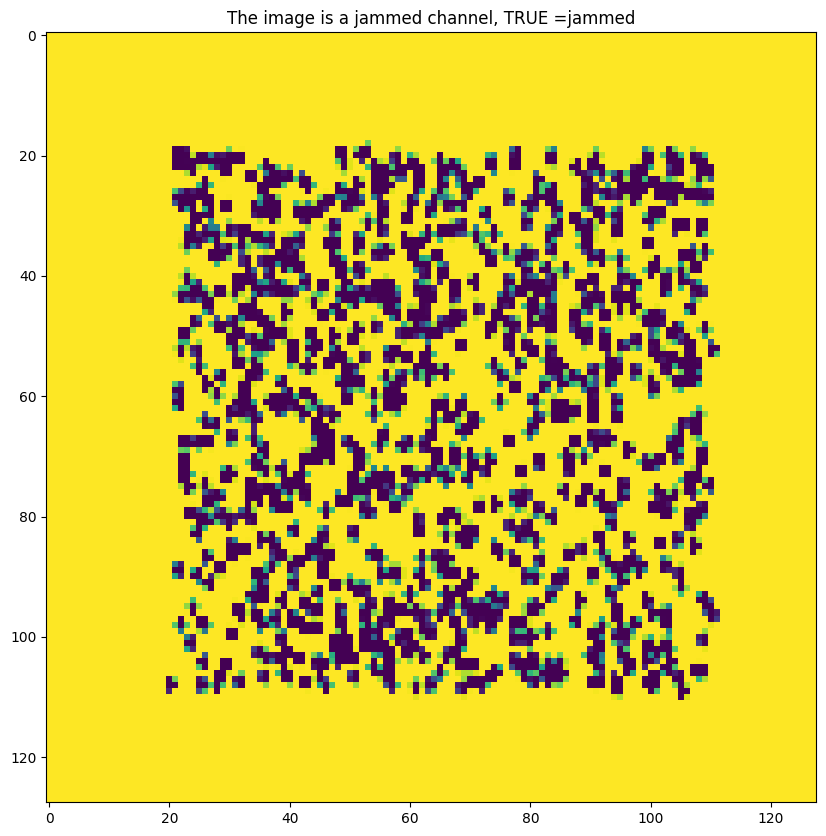

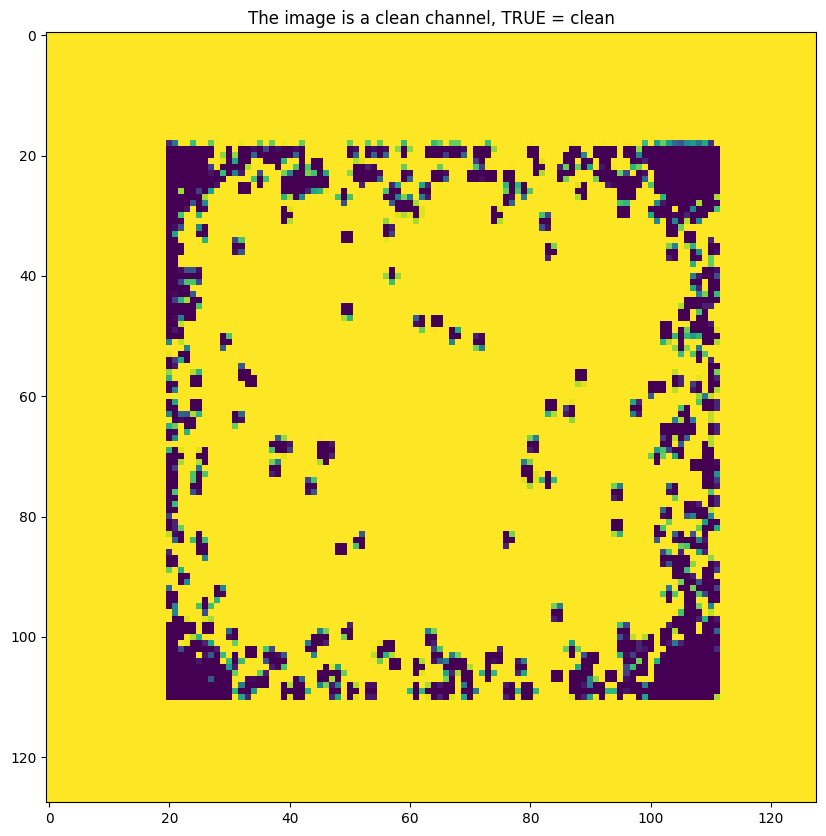

In [17]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [20]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [30]:
values_th=np.arange(normal_values[0],jammed_values[0],0.0005)
print(len(values_th))

42


In [22]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0229


  0%|          | 2/800 [00:00<01:09, 11.44it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0475


  0%|          | 4/800 [00:00<01:06, 11.92it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0295


  1%|          | 6/800 [00:00<01:06, 11.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0488


  1%|          | 8/800 [00:00<01:06, 11.86it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0474


  1%|▏         | 10/800 [00:00<01:04, 12.23it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0490


  2%|▏         | 12/800 [00:00<01:04, 12.18it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0296


  2%|▏         | 14/800 [00:01<01:05, 11.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0293


  2%|▏         | 16/800 [00:01<01:02, 12.45it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0272


  2%|▏         | 18/800 [00:01<01:02, 12.50it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0278


  2%|▎         | 20/800 [00:01<01:02, 12.42it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0485


  3%|▎         | 22/800 [00:01<01:07, 11.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0286


  3%|▎         | 24/800 [00:02<01:06, 11.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0262


  3%|▎         | 26/800 [00:02<01:05, 11.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0480


  4%|▎         | 28/800 [00:02<01:02, 12.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0496


  4%|▍         | 30/800 [00:02<00:57, 13.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0266


  4%|▍         | 32/800 [00:02<00:53, 14.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0481


  4%|▍         | 34/800 [00:02<00:51, 14.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0492


  4%|▍         | 36/800 [00:02<00:50, 15.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


  5%|▍         | 38/800 [00:02<00:47, 15.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0482


  5%|▌         | 40/800 [00:03<00:47, 16.06it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0477


  5%|▌         | 42/800 [00:03<00:47, 16.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0487


  6%|▌         | 44/800 [00:03<00:47, 15.86it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0288


  6%|▌         | 46/800 [00:03<00:48, 15.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0305


  6%|▌         | 48/800 [00:03<00:46, 16.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


  6%|▋         | 50/800 [00:03<00:47, 15.75it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0478


  6%|▋         | 52/800 [00:03<00:48, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0498


  7%|▋         | 54/800 [00:03<00:46, 16.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0261


  7%|▋         | 56/800 [00:04<00:44, 16.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0278


  7%|▋         | 58/800 [00:04<00:46, 16.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0485


  8%|▊         | 60/800 [00:04<00:46, 16.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0273


  8%|▊         | 62/800 [00:04<00:46, 15.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


  8%|▊         | 64/800 [00:04<00:45, 16.09it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0477


  8%|▊         | 66/800 [00:04<00:46, 15.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0263


  8%|▊         | 68/800 [00:04<00:46, 15.89it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0480


  9%|▉         | 70/800 [00:04<00:44, 16.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0231


  9%|▉         | 72/800 [00:05<00:43, 16.61it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0482


  9%|▉         | 74/800 [00:05<00:44, 16.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0479


 10%|▉         | 76/800 [00:05<00:46, 15.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 10%|▉         | 78/800 [00:05<00:45, 15.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0286


 10%|█         | 80/800 [00:05<00:47, 15.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 10%|█         | 82/800 [00:05<00:46, 15.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0480


 10%|█         | 84/800 [00:05<00:46, 15.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0284


 11%|█         | 86/800 [00:05<00:46, 15.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0484


 11%|█         | 88/800 [00:06<00:45, 15.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 11%|█▏        | 90/800 [00:06<00:45, 15.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0250


 12%|█▏        | 92/800 [00:06<00:45, 15.50it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0482


 12%|█▏        | 94/800 [00:06<00:44, 15.74it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0261


 12%|█▏        | 96/800 [00:06<00:44, 15.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 12%|█▏        | 98/800 [00:06<00:44, 15.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 12%|█▎        | 100/800 [00:06<00:45, 15.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0483


 13%|█▎        | 102/800 [00:06<00:45, 15.20it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0273


 13%|█▎        | 104/800 [00:07<00:44, 15.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0315


 13%|█▎        | 106/800 [00:07<00:47, 14.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0478


 14%|█▎        | 108/800 [00:07<00:46, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0281


 14%|█▍        | 110/800 [00:07<00:44, 15.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0490


 14%|█▍        | 112/800 [00:07<00:44, 15.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0484


 14%|█▍        | 114/800 [00:07<00:43, 15.77it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0493


 14%|█▍        | 116/800 [00:07<00:42, 16.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0493


 15%|█▍        | 118/800 [00:07<00:41, 16.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 15%|█▌        | 120/800 [00:08<00:42, 15.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0476


 15%|█▌        | 122/800 [00:08<00:42, 15.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 16%|█▌        | 124/800 [00:08<00:43, 15.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0488


 16%|█▌        | 126/800 [00:08<00:44, 15.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 16%|█▌        | 128/800 [00:08<00:43, 15.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0302


 16%|█▋        | 130/800 [00:08<00:42, 15.76it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0492


 16%|█▋        | 132/800 [00:08<00:42, 15.62it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0488


 17%|█▋        | 134/800 [00:08<00:40, 16.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0489


 17%|█▋        | 136/800 [00:09<00:42, 15.60it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0262


 17%|█▋        | 138/800 [00:09<00:42, 15.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0489


 18%|█▊        | 140/800 [00:09<00:42, 15.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0489


 18%|█▊        | 142/800 [00:09<00:41, 15.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 18%|█▊        | 144/800 [00:09<00:41, 15.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0267


 18%|█▊        | 146/800 [00:09<00:41, 15.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0486


 18%|█▊        | 148/800 [00:09<00:41, 15.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0484


 19%|█▉        | 150/800 [00:10<00:42, 15.35it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0487


 19%|█▉        | 152/800 [00:10<00:41, 15.52it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0243


 19%|█▉        | 154/800 [00:10<00:41, 15.49it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0292


 20%|█▉        | 156/800 [00:10<00:40, 15.89it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0482


 20%|█▉        | 158/800 [00:10<00:41, 15.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0489


 20%|██        | 160/800 [00:10<00:41, 15.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0490


 20%|██        | 162/800 [00:10<00:43, 14.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0481


 20%|██        | 164/800 [00:10<00:41, 15.42it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0281


 21%|██        | 166/800 [00:11<00:41, 15.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0217


 21%|██        | 168/800 [00:11<00:40, 15.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0269


 21%|██▏       | 170/800 [00:11<00:40, 15.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0487


 22%|██▏       | 172/800 [00:11<00:39, 15.79it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0263


 22%|██▏       | 174/800 [00:11<00:38, 16.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0303


 22%|██▏       | 176/800 [00:11<00:38, 16.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 22%|██▏       | 178/800 [00:11<00:39, 15.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0272


 22%|██▎       | 180/800 [00:11<00:38, 15.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 23%|██▎       | 182/800 [00:12<00:38, 15.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0256


 23%|██▎       | 184/800 [00:12<00:38, 15.97it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0481


 23%|██▎       | 186/800 [00:12<00:41, 14.87it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0490


 24%|██▎       | 188/800 [00:12<01:24,  7.22it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0283


 24%|██▍       | 190/800 [00:13<01:15,  8.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0272


 24%|██▍       | 192/800 [00:13<01:09,  8.71it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0494


 24%|██▍       | 194/800 [00:13<01:04,  9.37it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0255


 24%|██▍       | 196/800 [00:13<01:00,  9.99it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0485


 25%|██▍       | 198/800 [00:13<00:59, 10.06it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0309


 25%|██▌       | 200/800 [00:14<00:57, 10.49it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0248


 25%|██▌       | 202/800 [00:14<00:56, 10.55it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0300


 26%|██▌       | 204/800 [00:14<00:58, 10.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0257


 26%|██▌       | 206/800 [00:14<00:53, 11.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0259


 26%|██▌       | 208/800 [00:14<00:50, 11.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0492


 26%|██▋       | 210/800 [00:14<00:48, 12.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 26%|██▋       | 212/800 [00:15<00:46, 12.62it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0500


 27%|██▋       | 214/800 [00:15<00:45, 13.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 27%|██▋       | 216/800 [00:15<00:44, 13.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0494


 27%|██▋       | 218/800 [00:15<00:42, 13.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0487


 28%|██▊       | 220/800 [00:15<00:42, 13.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0484


 28%|██▊       | 222/800 [00:15<00:42, 13.58it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0263


 28%|██▊       | 224/800 [00:15<00:43, 13.34it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0270


 28%|██▊       | 226/800 [00:16<00:43, 13.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0279


 28%|██▊       | 228/800 [00:16<00:43, 13.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0292


 29%|██▉       | 230/800 [00:16<00:43, 13.22it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0247


 29%|██▉       | 232/800 [00:16<00:41, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 29%|██▉       | 234/800 [00:16<00:40, 13.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0239


 30%|██▉       | 236/800 [00:16<00:40, 13.89it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0302


 30%|██▉       | 238/800 [00:16<00:41, 13.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 30%|███       | 240/800 [00:17<00:40, 13.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0292


 30%|███       | 242/800 [00:17<00:41, 13.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0482


 30%|███       | 244/800 [00:17<00:40, 13.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0488


 31%|███       | 246/800 [00:17<00:39, 13.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0290


 31%|███       | 248/800 [00:17<00:39, 14.15it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0487


 31%|███▏      | 250/800 [00:17<00:39, 14.07it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0297


 32%|███▏      | 252/800 [00:17<00:39, 13.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0258


 32%|███▏      | 254/800 [00:18<00:38, 14.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0303


 32%|███▏      | 256/800 [00:18<00:38, 14.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0492


 32%|███▏      | 258/800 [00:18<00:38, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 32%|███▎      | 260/800 [00:18<00:36, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0306


 33%|███▎      | 262/800 [00:18<00:36, 14.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0485


 33%|███▎      | 264/800 [00:18<00:37, 14.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0494


 33%|███▎      | 266/800 [00:18<00:36, 14.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 34%|███▎      | 268/800 [00:19<00:36, 14.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 34%|███▍      | 270/800 [00:19<00:35, 14.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0260


 34%|███▍      | 272/800 [00:19<00:35, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0492


 34%|███▍      | 274/800 [00:19<00:34, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


 34%|███▍      | 276/800 [00:19<00:34, 15.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0272


 35%|███▍      | 278/800 [00:19<00:34, 15.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0297


 35%|███▌      | 280/800 [00:19<00:35, 14.76it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0289


 35%|███▌      | 282/800 [00:19<00:34, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0256


 36%|███▌      | 284/800 [00:20<00:34, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 36%|███▌      | 286/800 [00:20<00:33, 15.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 36%|███▌      | 288/800 [00:20<00:32, 15.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 36%|███▋      | 290/800 [00:20<00:33, 15.02it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0303


 36%|███▋      | 292/800 [00:20<00:33, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0495


 37%|███▋      | 294/800 [00:20<00:34, 14.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0261


 37%|███▋      | 296/800 [00:20<00:33, 15.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0310


 37%|███▋      | 298/800 [00:21<00:34, 14.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0249


 38%|███▊      | 300/800 [00:21<00:33, 14.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0284


 38%|███▊      | 302/800 [00:21<00:33, 15.02it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0479


 38%|███▊      | 304/800 [00:21<00:31, 15.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0492


 38%|███▊      | 306/800 [00:21<00:32, 15.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 38%|███▊      | 308/800 [00:21<00:33, 14.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0483


 39%|███▉      | 310/800 [00:21<00:32, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 39%|███▉      | 312/800 [00:21<00:31, 15.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 39%|███▉      | 314/800 [00:22<00:32, 14.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0242


 40%|███▉      | 316/800 [00:22<00:33, 14.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 40%|███▉      | 318/800 [00:22<00:32, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 40%|████      | 320/800 [00:22<00:30, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0309


 40%|████      | 322/800 [00:22<00:30, 15.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 40%|████      | 324/800 [00:22<00:30, 15.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 41%|████      | 326/800 [00:22<00:31, 15.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0490


 41%|████      | 328/800 [00:23<00:30, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


 41%|████▏     | 330/800 [00:23<00:30, 15.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 42%|████▏     | 332/800 [00:23<00:30, 15.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0272


 42%|████▏     | 334/800 [00:23<00:30, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0265


 42%|████▏     | 336/800 [00:23<00:30, 15.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0476


 42%|████▏     | 338/800 [00:23<00:30, 15.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0266


 42%|████▎     | 340/800 [00:23<00:30, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0272


 43%|████▎     | 342/800 [00:23<00:29, 15.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0491


 43%|████▎     | 344/800 [00:24<00:29, 15.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0479


 43%|████▎     | 346/800 [00:24<00:29, 15.40it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0272


 44%|████▎     | 348/800 [00:24<00:29, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0257


 44%|████▍     | 350/800 [00:24<00:29, 15.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0490


 44%|████▍     | 352/800 [00:24<00:32, 13.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0284


 44%|████▍     | 354/800 [00:24<00:33, 13.41it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0260


 44%|████▍     | 356/800 [00:24<00:36, 12.30it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0262


 45%|████▍     | 358/800 [00:25<00:38, 11.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0482


 45%|████▌     | 360/800 [00:25<00:36, 11.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0485


 45%|████▌     | 362/800 [00:25<00:36, 12.06it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0288


 46%|████▌     | 364/800 [00:25<00:36, 12.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0249


 46%|████▌     | 366/800 [00:25<00:35, 12.17it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0269


 46%|████▌     | 368/800 [00:25<00:35, 12.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0267


 46%|████▋     | 370/800 [00:26<00:35, 12.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0260


 46%|████▋     | 372/800 [00:26<00:35, 12.12it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0493


 47%|████▋     | 374/800 [00:26<00:35, 11.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0481


 47%|████▋     | 376/800 [00:26<00:36, 11.77it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0230


 47%|████▋     | 378/800 [00:26<00:36, 11.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0259


 48%|████▊     | 380/800 [00:26<00:34, 12.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 48%|████▊     | 382/800 [00:27<00:33, 12.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


 48%|████▊     | 384/800 [00:27<00:31, 13.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0482


 48%|████▊     | 386/800 [00:27<00:29, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 48%|████▊     | 388/800 [00:27<00:27, 14.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0253


 49%|████▉     | 390/800 [00:27<00:27, 15.18it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0480


 49%|████▉     | 392/800 [00:27<00:27, 14.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0481


 49%|████▉     | 394/800 [00:27<00:26, 15.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0252


 50%|████▉     | 396/800 [00:28<00:26, 15.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0475


 50%|████▉     | 398/800 [00:28<00:25, 15.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 50%|█████     | 400/800 [00:28<00:25, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0486


 50%|█████     | 402/800 [00:28<00:26, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0490


 50%|█████     | 404/800 [00:28<00:25, 15.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0310


 51%|█████     | 406/800 [00:28<00:25, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 51%|█████     | 408/800 [00:28<00:25, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0308


 51%|█████▏    | 410/800 [00:28<00:24, 15.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0489


 52%|█████▏    | 412/800 [00:29<00:24, 15.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0487


 52%|█████▏    | 414/800 [00:29<00:24, 15.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 52%|█████▏    | 416/800 [00:29<00:24, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 52%|█████▏    | 418/800 [00:29<00:24, 15.33it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0482


 52%|█████▎    | 420/800 [00:29<00:24, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 53%|█████▎    | 422/800 [00:29<00:24, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 53%|█████▎    | 424/800 [00:29<00:24, 15.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 53%|█████▎    | 426/800 [00:29<00:23, 15.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0305


 54%|█████▎    | 428/800 [00:30<00:24, 15.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0235


 54%|█████▍    | 430/800 [00:30<00:24, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0478


 54%|█████▍    | 432/800 [00:30<00:24, 15.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0494


 54%|█████▍    | 434/800 [00:30<00:23, 15.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0300


 55%|█████▍    | 436/800 [00:30<00:24, 15.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 55%|█████▍    | 438/800 [00:30<00:24, 15.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0267


 55%|█████▌    | 440/800 [00:30<00:24, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 55%|█████▌    | 442/800 [00:31<00:23, 15.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0476


 56%|█████▌    | 444/800 [00:31<00:23, 15.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0268


 56%|█████▌    | 446/800 [00:31<00:23, 15.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0290


 56%|█████▌    | 448/800 [00:31<00:22, 15.50it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0288


 56%|█████▋    | 450/800 [00:31<00:22, 15.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 56%|█████▋    | 452/800 [00:31<00:21, 15.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0309


 57%|█████▋    | 454/800 [00:31<00:22, 15.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0493


 57%|█████▋    | 456/800 [00:31<00:21, 15.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 57%|█████▋    | 458/800 [00:32<00:21, 15.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0487


 57%|█████▊    | 460/800 [00:32<00:21, 15.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0494


 58%|█████▊    | 462/800 [00:32<00:21, 15.83it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0270


 58%|█████▊    | 464/800 [00:32<00:21, 15.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 58%|█████▊    | 466/800 [00:32<00:21, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0265


 58%|█████▊    | 468/800 [00:32<00:21, 15.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0270


 59%|█████▉    | 470/800 [00:32<00:21, 15.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0329


 59%|█████▉    | 472/800 [00:32<00:21, 15.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0491


 59%|█████▉    | 474/800 [00:33<00:21, 14.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


 60%|█████▉    | 476/800 [00:33<00:21, 15.36it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0487


 60%|█████▉    | 478/800 [00:33<00:21, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0298


 60%|██████    | 480/800 [00:33<00:21, 14.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 60%|██████    | 482/800 [00:33<00:20, 15.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 60%|██████    | 484/800 [00:33<00:20, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0488


 61%|██████    | 486/800 [00:33<00:20, 15.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0493


 61%|██████    | 488/800 [00:33<00:20, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 61%|██████▏   | 490/800 [00:34<00:20, 15.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0482


 62%|██████▏   | 492/800 [00:34<00:20, 15.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0266


 62%|██████▏   | 494/800 [00:34<00:20, 15.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0491


 62%|██████▏   | 496/800 [00:34<00:19, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 62%|██████▏   | 498/800 [00:34<00:19, 15.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0478


 62%|██████▎   | 500/800 [00:34<00:19, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0262


 63%|██████▎   | 502/800 [00:34<00:19, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 63%|██████▎   | 504/800 [00:35<00:19, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 63%|██████▎   | 506/800 [00:35<00:18, 15.49it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0285


 64%|██████▎   | 508/800 [00:35<00:18, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 64%|██████▍   | 510/800 [00:35<00:18, 15.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 64%|██████▍   | 512/800 [00:35<00:18, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0480


 64%|██████▍   | 514/800 [00:35<00:18, 15.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 64%|██████▍   | 516/800 [00:35<00:18, 15.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0492


 65%|██████▍   | 518/800 [00:35<00:18, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


 65%|██████▌   | 520/800 [00:36<00:18, 15.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0299


 65%|██████▌   | 522/800 [00:36<00:18, 15.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0261


 66%|██████▌   | 524/800 [00:36<00:17, 15.34it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0259


 66%|██████▌   | 526/800 [00:36<00:18, 15.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0273


 66%|██████▌   | 528/800 [00:36<00:17, 15.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 66%|██████▋   | 530/800 [00:36<00:17, 15.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 66%|██████▋   | 532/800 [00:36<00:17, 14.95it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0488


 67%|██████▋   | 534/800 [00:37<00:19, 13.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0486


 67%|██████▋   | 536/800 [00:37<00:20, 12.76it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0475


 67%|██████▋   | 538/800 [00:37<00:20, 12.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0278


 68%|██████▊   | 540/800 [00:37<00:21, 11.95it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0484


 68%|██████▊   | 542/800 [00:37<00:22, 11.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0272


 68%|██████▊   | 544/800 [00:37<00:21, 11.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0288


 68%|██████▊   | 546/800 [00:38<00:21, 11.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0293


 68%|██████▊   | 548/800 [00:38<00:21, 11.58it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0486


 69%|██████▉   | 550/800 [00:38<00:22, 11.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0248


 69%|██████▉   | 552/800 [00:38<00:22, 11.11it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0293


 69%|██████▉   | 554/800 [00:38<00:21, 11.25it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0485


 70%|██████▉   | 556/800 [00:39<00:21, 11.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0489


 70%|██████▉   | 558/800 [00:39<00:21, 11.36it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0482


 70%|███████   | 560/800 [00:39<00:21, 11.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0480


 70%|███████   | 562/800 [00:39<00:19, 12.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0295


 70%|███████   | 564/800 [00:39<00:18, 12.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 71%|███████   | 566/800 [00:39<00:17, 13.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 71%|███████   | 568/800 [00:39<00:16, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0491


 71%|███████▏  | 570/800 [00:40<00:16, 14.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0269


 72%|███████▏  | 572/800 [00:40<00:15, 14.73it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0268


 72%|███████▏  | 574/800 [00:40<00:15, 14.62it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0310


 72%|███████▏  | 576/800 [00:40<00:15, 14.80it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0309


 72%|███████▏  | 578/800 [00:40<00:14, 15.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0293


 72%|███████▎  | 580/800 [00:40<00:14, 15.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0289


 73%|███████▎  | 582/800 [00:40<00:14, 14.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0479


 73%|███████▎  | 584/800 [00:40<00:14, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0299


 73%|███████▎  | 586/800 [00:41<00:14, 14.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0472


 74%|███████▎  | 588/800 [00:41<00:14, 14.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 74%|███████▍  | 590/800 [00:41<00:13, 15.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 74%|███████▍  | 592/800 [00:41<00:13, 15.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0308


 74%|███████▍  | 594/800 [00:41<00:13, 14.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 74%|███████▍  | 596/800 [00:41<00:13, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0491


 75%|███████▍  | 598/800 [00:41<00:13, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 75%|███████▌  | 600/800 [00:42<00:13, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 75%|███████▌  | 602/800 [00:42<00:13, 15.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 76%|███████▌  | 604/800 [00:42<00:13, 14.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 76%|███████▌  | 606/800 [00:42<00:12, 15.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0478


 76%|███████▌  | 608/800 [00:42<00:12, 15.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0259


 76%|███████▋  | 610/800 [00:42<00:13, 14.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0478


 76%|███████▋  | 612/800 [00:42<00:12, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 77%|███████▋  | 614/800 [00:42<00:12, 14.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0481


 77%|███████▋  | 616/800 [00:43<00:12, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0296


 77%|███████▋  | 618/800 [00:43<00:12, 14.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0494


 78%|███████▊  | 620/800 [00:43<00:12, 14.80it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0501


 78%|███████▊  | 622/800 [00:43<00:11, 14.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0278


 78%|███████▊  | 624/800 [00:43<00:11, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0494


 78%|███████▊  | 626/800 [00:43<00:11, 15.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 78%|███████▊  | 628/800 [00:43<00:11, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 79%|███████▉  | 630/800 [00:44<00:11, 15.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0296


 79%|███████▉  | 632/800 [00:44<00:11, 14.75it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0484


 79%|███████▉  | 634/800 [00:44<00:11, 14.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 80%|███████▉  | 636/800 [00:44<00:10, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0494


 80%|███████▉  | 638/800 [00:44<00:10, 14.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 80%|████████  | 640/800 [00:44<00:10, 14.88it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0321


 80%|████████  | 642/800 [00:44<00:10, 15.33it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0295


 80%|████████  | 644/800 [00:44<00:10, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0494


 81%|████████  | 646/800 [00:45<00:10, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0473


 81%|████████  | 648/800 [00:45<00:10, 14.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0240


 81%|████████▏ | 650/800 [00:45<00:10, 14.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 82%|████████▏ | 652/800 [00:45<00:09, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 82%|████████▏ | 654/800 [00:45<00:09, 14.80it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0480


 82%|████████▏ | 656/800 [00:45<00:09, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0265


 82%|████████▏ | 658/800 [00:45<00:09, 15.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 82%|████████▎ | 660/800 [00:46<00:09, 15.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0495


 83%|████████▎ | 662/800 [00:46<00:09, 14.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 83%|████████▎ | 664/800 [00:46<00:09, 14.50it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0487


 83%|████████▎ | 666/800 [00:46<00:09, 14.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0481


 84%|████████▎ | 668/800 [00:46<00:08, 14.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 84%|████████▍ | 670/800 [00:46<00:08, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 84%|████████▍ | 672/800 [00:46<00:08, 14.81it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0499


 84%|████████▍ | 674/800 [00:46<00:08, 15.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0281


 84%|████████▍ | 676/800 [00:47<00:08, 15.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 85%|████████▍ | 678/800 [00:47<00:08, 15.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 85%|████████▌ | 680/800 [00:47<00:08, 14.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0486


 85%|████████▌ | 682/800 [00:47<00:08, 14.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 86%|████████▌ | 684/800 [00:47<00:08, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 86%|████████▌ | 686/800 [00:47<00:07, 14.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 86%|████████▌ | 688/800 [00:47<00:07, 14.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 86%|████████▋ | 690/800 [00:48<00:07, 14.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0481


 86%|████████▋ | 692/800 [00:48<00:07, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 87%|████████▋ | 694/800 [00:48<00:07, 13.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0301


 87%|████████▋ | 696/800 [00:48<00:07, 13.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0277


 87%|████████▋ | 698/800 [00:48<00:07, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0480


 88%|████████▊ | 700/800 [00:48<00:07, 13.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0481


 88%|████████▊ | 702/800 [00:48<00:06, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


 88%|████████▊ | 704/800 [00:49<00:06, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


 88%|████████▊ | 706/800 [00:49<00:06, 14.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0236


 88%|████████▊ | 708/800 [00:49<00:06, 14.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0488


 89%|████████▉ | 710/800 [00:49<00:06, 13.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


 89%|████████▉ | 712/800 [00:49<00:06, 13.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0483


 89%|████████▉ | 714/800 [00:49<00:06, 12.34it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0261


 90%|████████▉ | 716/800 [00:50<00:07, 11.96it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0289


 90%|████████▉ | 718/800 [00:50<00:07, 11.66it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0482


 90%|█████████ | 720/800 [00:50<00:07, 11.41it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0486


 90%|█████████ | 722/800 [00:50<00:07, 10.73it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0277


 90%|█████████ | 724/800 [00:50<00:06, 11.02it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0300


 91%|█████████ | 726/800 [00:50<00:06, 11.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0300


 91%|█████████ | 728/800 [00:51<00:06, 11.58it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0253


 91%|█████████▏| 730/800 [00:51<00:05, 11.75it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0229


 92%|█████████▏| 732/800 [00:51<00:05, 11.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0289


 92%|█████████▏| 734/800 [00:51<00:05, 11.51it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0490


 92%|█████████▏| 736/800 [00:51<00:05, 11.68it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0284


 92%|█████████▏| 738/800 [00:51<00:05, 11.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0483


 92%|█████████▎| 740/800 [00:52<00:04, 12.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 93%|█████████▎| 742/800 [00:52<00:04, 13.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 93%|█████████▎| 744/800 [00:52<00:04, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 93%|█████████▎| 746/800 [00:52<00:03, 14.10it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0484


 94%|█████████▎| 748/800 [00:52<00:03, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


 94%|█████████▍| 750/800 [00:52<00:03, 14.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


 94%|█████████▍| 752/800 [00:52<00:03, 14.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 94%|█████████▍| 754/800 [00:53<00:03, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 94%|█████████▍| 756/800 [00:53<00:03, 14.63it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0249


 95%|█████████▍| 758/800 [00:53<00:02, 14.93it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0290


 95%|█████████▌| 760/800 [00:53<00:02, 15.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0261


 95%|█████████▌| 762/800 [00:53<00:02, 15.43it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0303


 96%|█████████▌| 764/800 [00:53<00:02, 15.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


 96%|█████████▌| 766/800 [00:53<00:02, 14.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0490


 96%|█████████▌| 768/800 [00:53<00:02, 14.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0486


 96%|█████████▋| 770/800 [00:54<00:02, 14.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


 96%|█████████▋| 772/800 [00:54<00:01, 14.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 97%|█████████▋| 774/800 [00:54<00:01, 14.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0478


 97%|█████████▋| 776/800 [00:54<00:01, 14.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0293


 97%|█████████▋| 778/800 [00:54<00:01, 14.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 98%|█████████▊| 780/800 [00:54<00:01, 14.88it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0492


 98%|█████████▊| 782/800 [00:54<00:01, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0247


 98%|█████████▊| 784/800 [00:55<00:01, 14.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0279


 98%|█████████▊| 786/800 [00:55<00:01, 13.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0492


 98%|█████████▊| 788/800 [00:55<00:00, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0257


 99%|█████████▉| 790/800 [00:55<00:00, 14.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0259


 99%|█████████▉| 792/800 [00:55<00:00, 14.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 99%|█████████▉| 794/800 [00:55<00:00, 14.45it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0296


100%|█████████▉| 796/800 [00:55<00:00, 14.36it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0484


100%|█████████▉| 798/800 [00:56<00:00, 14.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


100%|██████████| 800/800 [00:56<00:00, 14.23it/s]

800


In [31]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [32]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [33]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.02375, 0.1225]
[0.2775, 0.24875, 0.20375, 0.155, 0.09, 0.05875, 0.02875, 0.00625, 0.005, 0.0025, 0.0025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


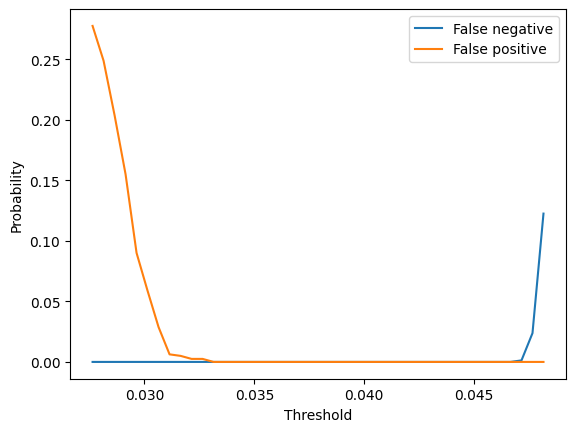

In [40]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [18]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0229


  0%|          | 2/800 [00:00<00:57, 13.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0475


  0%|          | 4/800 [00:00<00:50, 15.65it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0295


  1%|          | 6/800 [00:00<00:47, 16.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0488


  1%|          | 8/800 [00:00<00:47, 16.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0474


  1%|▏         | 10/800 [00:00<00:46, 17.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


  2%|▏         | 12/800 [00:00<00:46, 16.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0296


  2%|▏         | 14/800 [00:00<00:47, 16.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


  2%|▏         | 16/800 [00:00<00:47, 16.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0272


  2%|▏         | 18/800 [00:01<00:50, 15.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0278


  2%|▎         | 20/800 [00:01<00:49, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


  3%|▎         | 22/800 [00:01<00:48, 15.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


  3%|▎         | 24/800 [00:01<00:48, 16.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0262


  3%|▎         | 26/800 [00:01<00:47, 16.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0480


  4%|▎         | 28/800 [00:01<00:47, 16.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0496


  4%|▍         | 30/800 [00:01<00:49, 15.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0266


  4%|▍         | 32/800 [00:02<00:49, 15.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0481


  4%|▍         | 34/800 [00:02<00:49, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0492


  4%|▍         | 36/800 [00:02<00:46, 16.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


  5%|▍         | 38/800 [00:02<00:47, 16.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0482


  5%|▌         | 40/800 [00:02<00:46, 16.37it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0477


  5%|▌         | 42/800 [00:02<00:46, 16.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0487


  6%|▌         | 44/800 [00:02<00:47, 15.92it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0288


  6%|▌         | 46/800 [00:02<00:47, 15.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0305


  6%|▌         | 48/800 [00:02<00:46, 16.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


  6%|▋         | 50/800 [00:03<00:46, 16.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0478


  6%|▋         | 52/800 [00:03<00:46, 16.20it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0498


  7%|▋         | 54/800 [00:03<00:44, 16.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0261


  7%|▋         | 56/800 [00:03<00:45, 16.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0278


  7%|▋         | 58/800 [00:03<00:45, 16.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


  8%|▊         | 60/800 [00:03<00:46, 15.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0273


  8%|▊         | 62/800 [00:03<00:47, 15.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


  8%|▊         | 64/800 [00:03<00:46, 15.78it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0477


  8%|▊         | 66/800 [00:04<00:46, 15.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0263


  8%|▊         | 68/800 [00:04<00:44, 16.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0480


  9%|▉         | 70/800 [00:04<00:44, 16.54it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0231


  9%|▉         | 72/800 [00:04<00:44, 16.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


  9%|▉         | 74/800 [00:04<00:46, 15.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 10%|▉         | 76/800 [00:05<01:24,  8.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0290


 10%|▉         | 78/800 [00:05<01:14,  9.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0286


 10%|█         | 80/800 [00:05<01:07, 10.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 10%|█         | 82/800 [00:05<01:01, 11.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


 10%|█         | 84/800 [00:05<00:59, 12.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0284


 11%|█         | 86/800 [00:05<00:58, 12.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 11%|█         | 88/800 [00:05<00:56, 12.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0293


 11%|█▏        | 90/800 [00:06<00:55, 12.89it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0250


 12%|█▏        | 92/800 [00:06<00:55, 12.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 12%|█▏        | 94/800 [00:06<00:52, 13.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0261


 12%|█▏        | 96/800 [00:06<00:51, 13.67it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0292


 12%|█▏        | 98/800 [00:06<00:50, 13.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0482


 12%|█▎        | 100/800 [00:06<00:51, 13.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0483


 13%|█▎        | 102/800 [00:06<00:49, 14.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0273


 13%|█▎        | 104/800 [00:07<00:49, 13.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0315


 13%|█▎        | 106/800 [00:07<00:48, 14.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0478


 14%|█▎        | 108/800 [00:07<00:50, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0281


 14%|█▍        | 110/800 [00:07<00:49, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 14%|█▍        | 112/800 [00:07<00:48, 14.25it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0484


 14%|█▍        | 114/800 [00:07<00:52, 13.18it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0493


 14%|█▍        | 116/800 [00:08<00:57, 11.90it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0493


 15%|█▍        | 118/800 [00:08<00:58, 11.63it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0489


 15%|█▌        | 120/800 [00:08<00:59, 11.51it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0476


 15%|█▌        | 122/800 [00:08<00:59, 11.37it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0489


 16%|█▌        | 124/800 [00:08<01:00, 11.10it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0488


 16%|█▌        | 126/800 [00:08<01:01, 10.96it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0288


 16%|█▌        | 128/800 [00:09<01:00, 11.14it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0302


 16%|█▋        | 130/800 [00:09<00:59, 11.19it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0492


 16%|█▋        | 132/800 [00:09<01:00, 11.10it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0488


 17%|█▋        | 134/800 [00:09<01:01, 10.79it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0489


 17%|█▋        | 136/800 [00:09<01:03, 10.49it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0262


 17%|█▋        | 138/800 [00:10<01:02, 10.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0489


 18%|█▊        | 140/800 [00:10<00:57, 11.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0489


 18%|█▊        | 142/800 [00:10<00:55, 11.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0288


 18%|█▊        | 144/800 [00:10<00:52, 12.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 18%|█▊        | 146/800 [00:10<00:50, 12.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 18%|█▊        | 148/800 [00:10<00:47, 13.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0484


 19%|█▉        | 150/800 [00:10<00:47, 13.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 19%|█▉        | 152/800 [00:11<00:47, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0243


 19%|█▉        | 154/800 [00:11<00:45, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 20%|█▉        | 156/800 [00:11<00:43, 14.65it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0482


 20%|█▉        | 158/800 [00:11<00:45, 14.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 20%|██        | 160/800 [00:11<00:45, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 20%|██        | 162/800 [00:11<00:43, 14.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0481


 20%|██        | 164/800 [00:11<00:44, 14.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 21%|██        | 166/800 [00:12<00:42, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0217


 21%|██        | 168/800 [00:12<00:43, 14.58it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0269


 21%|██▏       | 170/800 [00:12<00:43, 14.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 22%|██▏       | 172/800 [00:12<00:42, 14.76it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0263


 22%|██▏       | 174/800 [00:12<00:41, 15.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0303


 22%|██▏       | 176/800 [00:12<00:41, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 22%|██▏       | 178/800 [00:12<00:41, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 22%|██▎       | 180/800 [00:12<00:40, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 23%|██▎       | 182/800 [00:13<00:39, 15.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0256


 23%|██▎       | 184/800 [00:13<00:41, 14.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0481


 23%|██▎       | 186/800 [00:13<00:41, 14.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0490


 24%|██▎       | 188/800 [00:13<00:39, 15.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0283


 24%|██▍       | 190/800 [00:13<00:39, 15.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0272


 24%|██▍       | 192/800 [00:13<00:40, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0494


 24%|██▍       | 194/800 [00:13<00:39, 15.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0255


 24%|██▍       | 196/800 [00:14<00:39, 15.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 25%|██▍       | 198/800 [00:14<00:38, 15.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


 25%|██▌       | 200/800 [00:14<00:38, 15.58it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0248


 25%|██▌       | 202/800 [00:14<00:38, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


 26%|██▌       | 204/800 [00:14<00:36, 16.12it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0257


 26%|██▌       | 206/800 [00:14<00:36, 16.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0259


 26%|██▌       | 208/800 [00:14<00:37, 15.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0492


 26%|██▋       | 210/800 [00:14<00:37, 15.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 26%|██▋       | 212/800 [00:15<00:36, 15.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0500


 27%|██▋       | 214/800 [00:15<00:37, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


 27%|██▋       | 216/800 [00:15<00:38, 14.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0494


 27%|██▋       | 218/800 [00:15<00:39, 14.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0487


 28%|██▊       | 220/800 [00:15<00:38, 14.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 28%|██▊       | 222/800 [00:15<00:37, 15.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0263


 28%|██▊       | 224/800 [00:15<00:37, 15.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0270


 28%|██▊       | 226/800 [00:15<00:37, 15.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0279


 28%|██▊       | 228/800 [00:16<00:39, 14.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 29%|██▉       | 230/800 [00:16<00:38, 14.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0247


 29%|██▉       | 232/800 [00:16<00:36, 15.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 29%|██▉       | 234/800 [00:16<00:37, 15.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0239


 30%|██▉       | 236/800 [00:16<00:36, 15.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0302


 30%|██▉       | 238/800 [00:16<00:36, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 30%|███       | 240/800 [00:16<00:36, 15.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 30%|███       | 242/800 [00:17<00:35, 15.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 30%|███       | 244/800 [00:17<00:36, 15.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 31%|███       | 246/800 [00:17<00:37, 14.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 31%|███       | 248/800 [00:17<00:37, 14.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 31%|███▏      | 250/800 [00:17<00:37, 14.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0297


 32%|███▏      | 252/800 [00:17<00:37, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0258


 32%|███▏      | 254/800 [00:17<00:36, 15.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0303


 32%|███▏      | 256/800 [00:17<00:36, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0492


 32%|███▏      | 258/800 [00:18<00:35, 15.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0488


 32%|███▎      | 260/800 [00:18<00:37, 14.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0306


 33%|███▎      | 262/800 [00:18<00:37, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 33%|███▎      | 264/800 [00:18<00:36, 14.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0494


 33%|███▎      | 266/800 [00:18<00:36, 14.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0487


 34%|███▎      | 268/800 [00:18<00:36, 14.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 34%|███▍      | 270/800 [00:18<00:35, 15.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0260


 34%|███▍      | 272/800 [00:19<00:35, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0492


 34%|███▍      | 274/800 [00:19<00:35, 14.62it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 34%|███▍      | 276/800 [00:19<00:36, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 35%|███▍      | 278/800 [00:19<00:36, 14.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0297


 35%|███▌      | 280/800 [00:19<00:35, 14.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0289


 35%|███▌      | 282/800 [00:19<00:34, 14.85it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0256


 36%|███▌      | 284/800 [00:19<00:35, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 36%|███▌      | 286/800 [00:20<00:35, 14.63it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0486


 36%|███▌      | 288/800 [00:20<00:41, 12.21it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0491


 36%|███▋      | 290/800 [00:20<00:42, 12.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0303


 36%|███▋      | 292/800 [00:20<00:44, 11.51it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0495


 37%|███▋      | 294/800 [00:20<00:43, 11.63it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0261


 37%|███▋      | 296/800 [00:20<00:44, 11.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0310


 37%|███▋      | 298/800 [00:21<00:44, 11.23it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0249


 38%|███▊      | 300/800 [00:21<00:43, 11.45it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0284


 38%|███▊      | 302/800 [00:21<00:42, 11.65it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0479


 38%|███▊      | 304/800 [00:21<00:44, 11.27it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0492


 38%|███▊      | 306/800 [00:21<00:44, 10.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0484


 38%|███▊      | 308/800 [00:22<00:45, 10.90it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0483


 39%|███▉      | 310/800 [00:22<00:45, 10.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0487


 39%|███▉      | 312/800 [00:22<00:45, 10.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0480


 39%|███▉      | 314/800 [00:22<00:41, 11.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0242


 40%|███▉      | 316/800 [00:22<00:38, 12.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 40%|███▉      | 318/800 [00:22<00:36, 13.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0491


 40%|████      | 320/800 [00:22<00:35, 13.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0309


 40%|████      | 322/800 [00:23<00:34, 13.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 40%|████      | 324/800 [00:23<00:33, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 41%|████      | 326/800 [00:23<00:32, 14.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 41%|████      | 328/800 [00:23<00:31, 14.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 41%|████▏     | 330/800 [00:23<00:31, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0486


 42%|████▏     | 332/800 [00:23<00:31, 14.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 42%|████▏     | 334/800 [00:23<00:30, 15.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0265


 42%|████▏     | 336/800 [00:24<00:30, 15.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0476


 42%|████▏     | 338/800 [00:24<00:30, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0266


 42%|████▎     | 340/800 [00:24<00:30, 15.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 43%|████▎     | 342/800 [00:24<00:29, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0491


 43%|████▎     | 344/800 [00:24<00:30, 15.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 43%|████▎     | 346/800 [00:24<00:31, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 44%|████▎     | 348/800 [00:24<00:30, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0257


 44%|████▍     | 350/800 [00:24<00:30, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 44%|████▍     | 352/800 [00:25<00:29, 15.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 44%|████▍     | 354/800 [00:25<00:29, 14.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0260


 44%|████▍     | 356/800 [00:25<00:29, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0262


 45%|████▍     | 358/800 [00:25<00:28, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


 45%|████▌     | 360/800 [00:25<00:28, 15.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 45%|████▌     | 362/800 [00:25<00:27, 15.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0288


 46%|████▌     | 364/800 [00:25<00:28, 15.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0249


 46%|████▌     | 366/800 [00:25<00:29, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0269


 46%|████▌     | 368/800 [00:26<00:28, 15.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 46%|████▋     | 370/800 [00:26<00:28, 15.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0260


 46%|████▋     | 372/800 [00:26<00:28, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0493


 47%|████▋     | 374/800 [00:26<00:29, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0481


 47%|████▋     | 376/800 [00:26<00:28, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0230


 47%|████▋     | 378/800 [00:26<00:27, 15.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0259


 48%|████▊     | 380/800 [00:26<00:27, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 48%|████▊     | 382/800 [00:27<00:27, 15.00it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 48%|████▊     | 384/800 [00:27<00:27, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 48%|████▊     | 386/800 [00:27<00:28, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 48%|████▊     | 388/800 [00:27<00:27, 14.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0253


 49%|████▉     | 390/800 [00:27<00:28, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 49%|████▉     | 392/800 [00:27<00:27, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 49%|████▉     | 394/800 [00:27<00:26, 15.10it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0252


 50%|████▉     | 396/800 [00:27<00:26, 15.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0475


 50%|████▉     | 398/800 [00:28<00:26, 15.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0483


 50%|█████     | 400/800 [00:28<00:25, 15.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0486


 50%|█████     | 402/800 [00:28<00:26, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0490


 50%|█████     | 404/800 [00:28<00:26, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0310


 51%|█████     | 406/800 [00:28<00:26, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 51%|█████     | 408/800 [00:28<00:26, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0308


 51%|█████▏    | 410/800 [00:28<00:25, 15.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0489


 52%|█████▏    | 412/800 [00:29<00:24, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 52%|█████▏    | 414/800 [00:29<00:25, 15.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 52%|█████▏    | 416/800 [00:29<00:26, 14.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0272


 52%|█████▏    | 418/800 [00:29<00:26, 14.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 52%|█████▎    | 420/800 [00:29<00:25, 14.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 53%|█████▎    | 422/800 [00:29<00:25, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 53%|█████▎    | 424/800 [00:29<00:25, 14.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0288


 53%|█████▎    | 426/800 [00:29<00:24, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0305


 54%|█████▎    | 428/800 [00:30<00:24, 15.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0235


 54%|█████▍    | 430/800 [00:30<00:23, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0478


 54%|█████▍    | 432/800 [00:30<00:23, 15.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0494


 54%|█████▍    | 434/800 [00:30<00:24, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0300


 55%|█████▍    | 436/800 [00:30<00:23, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0481


 55%|█████▍    | 438/800 [00:30<00:23, 15.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 55%|█████▌    | 440/800 [00:30<00:23, 15.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 55%|█████▌    | 442/800 [00:31<00:23, 15.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0476


 56%|█████▌    | 444/800 [00:31<00:23, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


 56%|█████▌    | 446/800 [00:31<00:23, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 56%|█████▌    | 448/800 [00:31<00:22, 15.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 56%|█████▋    | 450/800 [00:31<00:22, 15.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


 56%|█████▋    | 452/800 [00:31<00:23, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0309


 57%|█████▋    | 454/800 [00:31<00:23, 14.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0493


 57%|█████▋    | 456/800 [00:31<00:23, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 57%|█████▋    | 458/800 [00:32<00:22, 15.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0487


 57%|█████▊    | 460/800 [00:32<00:22, 15.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0494


 58%|█████▊    | 462/800 [00:32<00:22, 14.70it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0270


 58%|█████▊    | 464/800 [00:32<00:24, 13.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0489


 58%|█████▊    | 466/800 [00:32<00:25, 13.01it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0265


 58%|█████▊    | 468/800 [00:32<00:27, 12.26it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0270


 59%|█████▉    | 470/800 [00:33<00:27, 12.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0329


 59%|█████▉    | 472/800 [00:33<00:28, 11.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0491


 59%|█████▉    | 474/800 [00:33<00:28, 11.57it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0274


 60%|█████▉    | 476/800 [00:33<00:28, 11.27it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0487


 60%|█████▉    | 478/800 [00:33<00:28, 11.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0298


 60%|██████    | 480/800 [00:33<00:27, 11.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0279


 60%|██████    | 482/800 [00:34<00:27, 11.36it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0491


 60%|██████    | 484/800 [00:34<00:26, 11.87it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0488


 61%|██████    | 486/800 [00:34<00:27, 11.32it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0493


 61%|██████    | 488/800 [00:34<00:27, 11.32it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0483


 61%|██████▏   | 490/800 [00:34<00:27, 11.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0482


 62%|██████▏   | 492/800 [00:34<00:26, 11.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0266


 62%|██████▏   | 494/800 [00:35<00:24, 12.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 62%|██████▏   | 496/800 [00:35<00:23, 12.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0486


 62%|██████▏   | 498/800 [00:35<00:22, 13.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0478


 62%|██████▎   | 500/800 [00:35<00:22, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0262


 63%|██████▎   | 502/800 [00:35<00:21, 13.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 63%|██████▎   | 504/800 [00:35<00:20, 14.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 63%|██████▎   | 506/800 [00:35<00:21, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 64%|██████▎   | 508/800 [00:36<00:20, 14.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 64%|██████▍   | 510/800 [00:36<00:19, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 64%|██████▍   | 512/800 [00:36<00:19, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 64%|██████▍   | 514/800 [00:36<00:19, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 64%|██████▍   | 516/800 [00:36<00:18, 15.15it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0492


 65%|██████▍   | 518/800 [00:36<00:18, 15.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 65%|██████▌   | 520/800 [00:36<00:18, 15.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 65%|██████▌   | 522/800 [00:37<00:18, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0261


 66%|██████▌   | 524/800 [00:37<00:17, 15.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0259


 66%|██████▌   | 526/800 [00:37<00:17, 15.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0273


 66%|██████▌   | 528/800 [00:37<00:18, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0267


 66%|██████▋   | 530/800 [00:37<00:18, 14.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


 66%|██████▋   | 532/800 [00:37<00:17, 15.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0488


 67%|██████▋   | 534/800 [00:37<00:17, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 67%|██████▋   | 536/800 [00:37<00:17, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0475


 67%|██████▋   | 538/800 [00:38<00:17, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 68%|██████▊   | 540/800 [00:38<00:17, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 68%|██████▊   | 542/800 [00:38<00:17, 15.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0272


 68%|██████▊   | 544/800 [00:38<00:16, 15.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 68%|██████▊   | 546/800 [00:38<00:17, 14.59it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0293


 68%|██████▊   | 548/800 [00:38<00:17, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 69%|██████▉   | 550/800 [00:38<00:17, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0248


 69%|██████▉   | 552/800 [00:39<00:17, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 69%|██████▉   | 554/800 [00:39<00:16, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 70%|██████▉   | 556/800 [00:39<00:16, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0489


 70%|██████▉   | 558/800 [00:39<00:16, 14.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 70%|███████   | 560/800 [00:39<00:16, 14.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 70%|███████   | 562/800 [00:39<00:16, 14.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0295


 70%|███████   | 564/800 [00:39<00:15, 14.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 71%|███████   | 566/800 [00:39<00:15, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 71%|███████   | 568/800 [00:40<00:15, 15.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0491


 71%|███████▏  | 570/800 [00:40<00:15, 14.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0269


 72%|███████▏  | 572/800 [00:40<00:15, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0268


 72%|███████▏  | 574/800 [00:40<00:15, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0310


 72%|███████▏  | 576/800 [00:40<00:15, 14.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0309


 72%|███████▏  | 578/800 [00:40<00:15, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 72%|███████▎  | 580/800 [00:40<00:15, 14.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 73%|███████▎  | 582/800 [00:41<00:14, 14.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0479


 73%|███████▎  | 584/800 [00:41<00:14, 14.54it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0299


 73%|███████▎  | 586/800 [00:41<00:14, 14.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0472


 74%|███████▎  | 588/800 [00:41<00:14, 14.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 74%|███████▍  | 590/800 [00:41<00:14, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 74%|███████▍  | 592/800 [00:41<00:14, 14.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0308


 74%|███████▍  | 594/800 [00:41<00:14, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0489


 74%|███████▍  | 596/800 [00:42<00:13, 15.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 75%|███████▍  | 598/800 [00:42<00:14, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 75%|███████▌  | 600/800 [00:42<00:13, 14.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 75%|███████▌  | 602/800 [00:42<00:13, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 76%|███████▌  | 604/800 [00:42<00:13, 14.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0490


 76%|███████▌  | 606/800 [00:42<00:13, 14.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0478


 76%|███████▌  | 608/800 [00:42<00:13, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0259


 76%|███████▋  | 610/800 [00:42<00:12, 14.94it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0478


 76%|███████▋  | 612/800 [00:43<00:12, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 77%|███████▋  | 614/800 [00:43<00:12, 15.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 77%|███████▋  | 616/800 [00:43<00:12, 15.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0296


 77%|███████▋  | 618/800 [00:43<00:12, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0494


 78%|███████▊  | 620/800 [00:43<00:12, 14.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0501


 78%|███████▊  | 622/800 [00:43<00:11, 15.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 78%|███████▊  | 624/800 [00:43<00:11, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0494


 78%|███████▊  | 626/800 [00:44<00:12, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 78%|███████▊  | 628/800 [00:44<00:11, 14.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 79%|███████▉  | 630/800 [00:44<00:11, 14.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0296


 79%|███████▉  | 632/800 [00:44<00:11, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 79%|███████▉  | 634/800 [00:44<00:11, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 80%|███████▉  | 636/800 [00:44<00:11, 14.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0494


 80%|███████▉  | 638/800 [00:44<00:11, 14.53it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0485


 80%|████████  | 640/800 [00:45<00:12, 12.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0321


 80%|████████  | 642/800 [00:45<00:12, 12.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0295


 80%|████████  | 644/800 [00:45<00:12, 12.37it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0494


 81%|████████  | 646/800 [00:45<00:12, 11.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0473


 81%|████████  | 648/800 [00:45<00:12, 11.74it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0240


 81%|████████▏ | 650/800 [00:45<00:12, 11.76it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0282


 82%|████████▏ | 652/800 [00:46<00:13, 11.22it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0288


 82%|████████▏ | 654/800 [00:46<00:12, 11.44it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0480


 82%|████████▏ | 656/800 [00:46<00:13, 10.91it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0265


 82%|████████▏ | 658/800 [00:46<00:13, 10.89it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0483


 82%|████████▎ | 660/800 [00:46<00:12, 10.87it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0495


 83%|████████▎ | 662/800 [00:47<00:12, 11.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0485


 83%|████████▎ | 664/800 [00:47<00:12, 10.94it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0487


 83%|████████▎ | 666/800 [00:47<00:11, 11.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0481


 84%|████████▎ | 668/800 [00:47<00:11, 11.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0490


 84%|████████▍ | 670/800 [00:47<00:10, 12.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0489


 84%|████████▍ | 672/800 [00:47<00:09, 13.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0499


 84%|████████▍ | 674/800 [00:47<00:09, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0281


 84%|████████▍ | 676/800 [00:48<00:09, 13.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0289


 85%|████████▍ | 678/800 [00:48<00:09, 13.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 85%|████████▌ | 680/800 [00:48<00:08, 13.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0486


 85%|████████▌ | 682/800 [00:48<00:08, 13.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0487


 86%|████████▌ | 684/800 [00:48<00:08, 13.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0488


 86%|████████▌ | 686/800 [00:48<00:08, 14.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 86%|████████▌ | 688/800 [00:48<00:07, 14.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 86%|████████▋ | 690/800 [00:49<00:07, 14.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0481


 86%|████████▋ | 692/800 [00:49<00:07, 14.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0285


 87%|████████▋ | 694/800 [00:49<00:07, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 87%|████████▋ | 696/800 [00:49<00:07, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 87%|████████▋ | 698/800 [00:49<00:06, 15.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 88%|████████▊ | 700/800 [00:49<00:06, 15.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0481


 88%|████████▊ | 702/800 [00:49<00:06, 14.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0482


 88%|████████▊ | 704/800 [00:50<00:06, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


 88%|████████▊ | 706/800 [00:50<00:06, 14.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0236


 88%|████████▊ | 708/800 [00:50<00:06, 14.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 89%|████████▉ | 710/800 [00:50<00:06, 14.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0480


 89%|████████▉ | 712/800 [00:50<00:06, 14.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 89%|████████▉ | 714/800 [00:50<00:05, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0261


 90%|████████▉ | 716/800 [00:50<00:05, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 90%|████████▉ | 718/800 [00:50<00:05, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 90%|█████████ | 720/800 [00:51<00:05, 14.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 90%|█████████ | 722/800 [00:51<00:05, 14.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0277


 90%|█████████ | 724/800 [00:51<00:05, 14.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0300


 91%|█████████ | 726/800 [00:51<00:05, 14.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0300


 91%|█████████ | 728/800 [00:51<00:04, 14.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0253


 91%|█████████▏| 730/800 [00:51<00:04, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0229


 92%|█████████▏| 732/800 [00:51<00:04, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 92%|█████████▏| 734/800 [00:52<00:04, 14.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 92%|█████████▏| 736/800 [00:52<00:04, 14.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0284


 92%|█████████▏| 738/800 [00:52<00:04, 14.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0483


 92%|█████████▎| 740/800 [00:52<00:04, 14.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0484


 93%|█████████▎| 742/800 [00:52<00:04, 14.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0271


 93%|█████████▎| 744/800 [00:52<00:03, 14.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 93%|█████████▎| 746/800 [00:52<00:03, 14.53it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0484


 94%|█████████▎| 748/800 [00:53<00:03, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0290


 94%|█████████▍| 750/800 [00:53<00:03, 14.62it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0482


 94%|█████████▍| 752/800 [00:53<00:03, 14.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0488


 94%|█████████▍| 754/800 [00:53<00:03, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 94%|█████████▍| 756/800 [00:53<00:02, 14.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0249


 95%|█████████▍| 758/800 [00:53<00:02, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 95%|█████████▌| 760/800 [00:53<00:02, 14.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0261


 95%|█████████▌| 762/800 [00:53<00:02, 15.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0303


 96%|█████████▌| 764/800 [00:54<00:02, 14.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0480


 96%|█████████▌| 766/800 [00:54<00:02, 14.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 96%|█████████▌| 768/800 [00:54<00:02, 15.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0486


 96%|█████████▋| 770/800 [00:54<00:02, 14.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0309


 96%|█████████▋| 772/800 [00:54<00:01, 15.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 97%|█████████▋| 774/800 [00:54<00:01, 15.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0478


 97%|█████████▋| 776/800 [00:54<00:01, 13.68it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0293


 97%|█████████▋| 778/800 [00:55<00:01, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 98%|█████████▊| 780/800 [00:55<00:01, 13.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0492


 98%|█████████▊| 782/800 [00:55<00:01, 13.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0247


 98%|█████████▊| 784/800 [00:55<00:01, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 98%|█████████▊| 786/800 [00:55<00:00, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0492


 98%|█████████▊| 788/800 [00:55<00:00, 14.74it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0257


 99%|█████████▉| 790/800 [00:55<00:00, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0259


 99%|█████████▉| 792/800 [00:56<00:00, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 99%|█████████▉| 794/800 [00:56<00:00, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


100%|█████████▉| 796/800 [00:56<00:00, 14.54it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0484


100%|█████████▉| 798/800 [00:56<00:00, 14.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


100%|██████████| 800/800 [00:56<00:00, 14.14it/s]


In [19]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 96.25 %


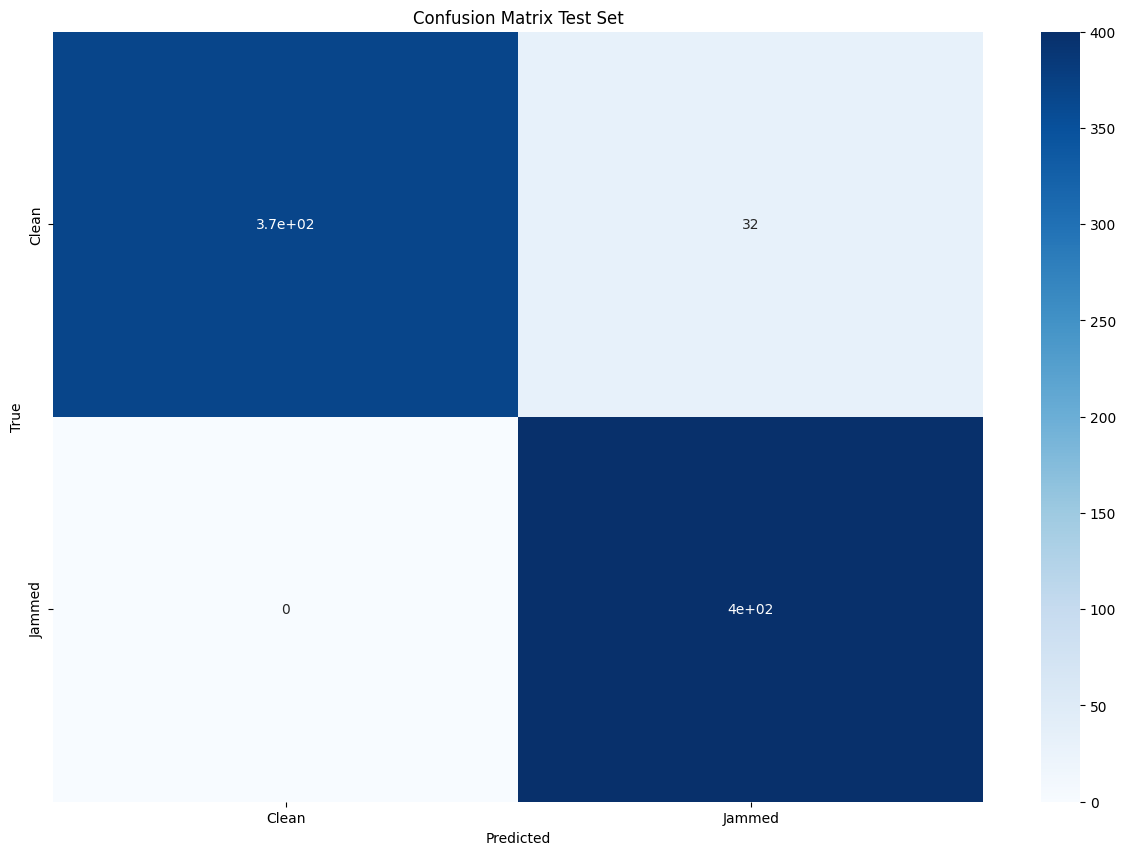

In [28]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold